In [1]:
from collections import defaultdict
import json
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import entropy
import seaborn as sns
import sklearn
from yellowbrick.cluster import KElbowVisualizer

import ihop
from ihop.community2vec import GensimCommunity2Vec
import ihop.clustering as ic


In [2]:

DATA_ROOT = Path("../data")
C2V_ROOT = DATA_ROOT / "community2vec"
STABILITY_METRICS_ROOT = DATA_ROOT / "cluster_stability"

MONTHS = sorted(["2021-04", "2021-05", "2021-06", "2021-07", "2021-08", "2021-09", "2021-10", "2021-11", "2021-12", "2022-01", "2022-02", "2022-03"
])

C2V_MODELS = [GensimCommunity2Vec.load(C2V_ROOT / f"RC_{m}"/"best_model") for m in MONTHS]

SUBREDDIT_COUNTS_CSVS = [C2V_ROOT / f"RC_{m}" / "subreddit_counts.csv" for m in MONTHS]

# Set up for clustering
RANDOM_SEEDS = [7, 17, 29, 32, 42, 53, 63, 70, 84, 96]
NUM_CLUSTERS = [5, 10, 50, 100, 175, 250, 400, 500]

# Basic Comparison of Top Most Popular Subreddits Month-to-Month

In order to build the community2vec models, we kept the top 10K subreddits in each month by number of comments posted. Since the top subreddits will change over time, we need to know quickly and by how much. This can be determined using the [Jaccard Index](https://en.wikipedia.org/wiki/Jaccard_index) of the top subreddits between each month. Let $S_1$ and $S_2$ be the top 10K subreddits for months 1 and 2 respectively, then the similarity and diversity of top subreddits between those months is $\frac{|S_1 \cap S_2|}{|S_1 \cup S_2|}$.

In [6]:
C2V_N_NEAREST_NEIGHBORS = 10
# Jaccard index for subreddits in community2vec models for each month in our year's worth of Reddit data
records = []
for i, model in enumerate(C2V_MODELS):
    month_label = MONTHS[i]
    print("Processing month:", month_label)
    current_model_keys = set(model.get_index_to_key())
    
    # Build up union and intersection values both for overall top subreddits and 
    # nearest neighbors under c2v models
    for j, model2 in enumerate(C2V_MODELS):
        month2_label = MONTHS[j]
        current_model2_keys = set(model2.get_index_to_key())
        union = current_model_keys.union(current_model2_keys)
        union_size = len(union)
        intersection_size = len(current_model_keys.intersection(current_model2_keys))

        rolling_sum_c2v_jaccard = 0

        # Check how much overlap there is between the nearest neighbors in the 
        # community2vec models
        for w in current_model_keys:
            nn_intersection_size = 0
            nn_union_size = C2V_N_NEAREST_NEIGHBORS
            model1_nearest_neighbors = set(model.get_nearest_neighbors(w, topn=C2V_N_NEAREST_NEIGHBORS))
            if w in model2.w2v_model.wv:
                model2_nearest_neighbors = set(model2.get_nearest_neighbors(w, topn=C2V_N_NEAREST_NEIGHBORS))
                nn_intersection_size = len(model1_nearest_neighbors.intersection(model2_nearest_neighbors))
                nn_union_size = len(model1_nearest_neighbors.union(model2_nearest_neighbors))
            subreddit_ji_index = nn_intersection_size / nn_union_size
            rolling_sum_c2v_jaccard += subreddit_ji_index

        
        c2v_nn_jaccard_avg = rolling_sum_c2v_jaccard / len(current_model_keys)
    
        records.append((month_label, month2_label, union_size, intersection_size, c2v_nn_jaccard_avg))
    
top_subreddit_ji_dataframe = pd.DataFrame.from_records(records, 
        columns = [
            "Month 1", 
            "Month 2", 
            "Union Size", 
            "Intersection Size", 
            f"Community2vec Top {C2V_N_NEAREST_NEIGHBORS} Nearest Subreddit Neighbors Jaccard Index"])
top_subreddit_ji_dataframe["Jaccard Index"] = top_subreddit_ji_dataframe["Intersection Size"] / top_subreddit_ji_dataframe["Union Size"]

display(top_subreddit_ji_dataframe)

Processing month: 2021-04
Processing month: 2021-05
Processing month: 2021-06
Processing month: 2021-07
Processing month: 2021-08
Processing month: 2021-09
Processing month: 2021-10
Processing month: 2021-11
Processing month: 2021-12
Processing month: 2022-01
Processing month: 2022-02
Processing month: 2022-03


Month 1  Month 2  Union Size  Intersection Size  \
0    2021-04  2021-04       10000              10000   
1    2021-04  2021-05       10805               9195   
2    2021-04  2021-06       11128               8872   
3    2021-04  2021-07       11350               8650   
4    2021-04  2021-08       11466               8534   
..       ...      ...         ...                ...   
139  2022-03  2021-11       11501               8499   
140  2022-03  2021-12       11375               8625   
141  2022-03  2022-01       11202               8798   
142  2022-03  2022-02       10749               9251   
143  2022-03  2022-03       10000              10000   

     Community2vec Top 10 Nearest Subreddit Neighbors Jaccard Index  \
0                                             1.000000                
1                                             0.391981                
2                                             0.360147                
3                                             0.339040                
4                                             0.327428                
..                                                 ...                
139                                           0.333720                
140                                           0.342240                
141                                           0.357977                
142                                           0.393537                
143                                           1.000000                

     Jaccard Index  
0         1.000000  
1         0.850995  
2         0.797268  
3         0.762115  
4         0.744287  
..             ...  
139       0.738979  
140       0.758242  
141       0.785395  
142       0.860638  
143       1.000000  

[144 rows x 6 columns]

Text(0.5, 1.0, 'Similarity between the Top Subreddits for each Month')

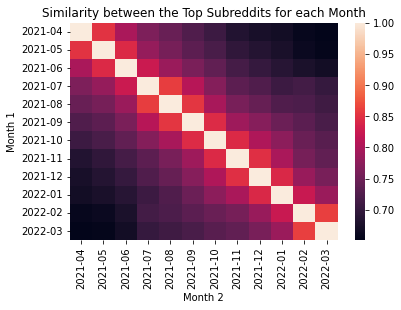

In [7]:
sns.heatmap(top_subreddit_ji_dataframe.pivot(index = "Month 1", columns = "Month 2", values = "Jaccard Index")).set_title("Similarity between the Top Subreddits for each Month")

Text(0.5, 1.0, 'Average Similarity between the Top 10 Nearest Subreddits in the Community2vec Model for each Month')

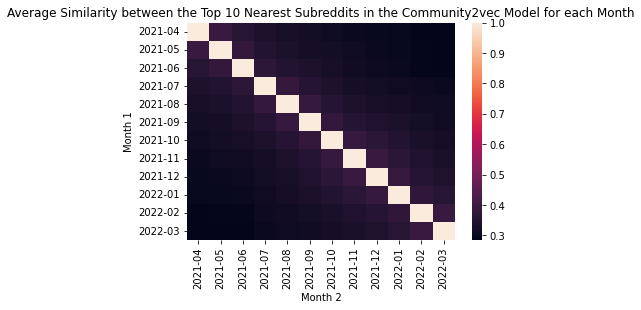

In [8]:
sns.heatmap(top_subreddit_ji_dataframe.pivot(index = "Month 1", columns = "Month 2", values = f"Community2vec Top {C2V_N_NEAREST_NEIGHBORS} Nearest Subreddit Neighbors Jaccard Index")).set_title(f"Average Similarity between the Top {C2V_N_NEAREST_NEIGHBORS} Nearest Subreddits in the Community2vec Model for each Month")

The closer to 1 the values are, the more similar the top subreddits are between those two months. This plot shows that months closer in time have more top subreddits in common that months further apart in time. 

# KMeans Clustering Elbow Heuristic
These diagrams demonstrate using the [Elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering)) to determine the appropriate number of clusters of subreddits in KMeans for each month. Ultimately, we'd like to use the granularity of clustering that provides the best human interpretability, but this method gives an indication of a good cut-off, where increasing the number of clusters will not give quantitative gains. 

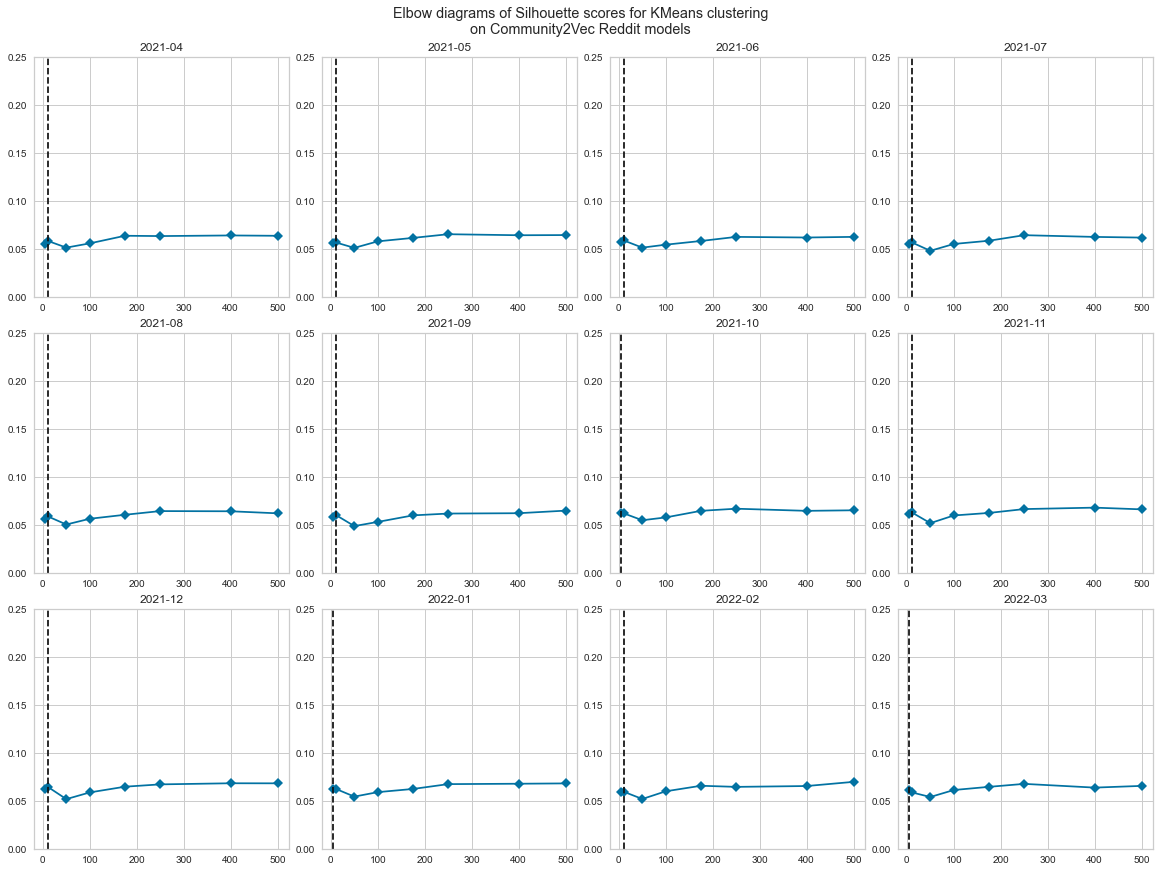

<Figure size 576x396 with 0 Axes>

In [96]:
# Use the Elbow methd to show if there's a "good" number of clusters that can be used
ax_counter = 0
nrows = 3
ncols = 4
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(16,12), constrained_layout=True)
fig.suptitle("Elbow diagrams of Silhouette scores for KMeans clustering\non Community2Vec Reddit models")
for month, c2v_model in zip(MONTHS, C2V_MODELS):
    row = int(ax_counter / ncols) 
    col = ax_counter % ncols
    ax = axes[row, col]
    ax.set(ylim=(0, 0.25))
    key_vectors = c2v_model.get_normed_vectors()
    kmeans_model = sklearn.cluster.KMeans(random_state=100)
    viz = KElbowVisualizer(kmeans_model, k=NUM_CLUSTERS, metric='silhouette', ax = ax, timings=False)
    ax.set_title(month)
    viz.fit(key_vectors)

    ax_counter +=1

plt.show()
plt.clf()


# Month-to-month Cluster Stability Comparison
We'd like to measure how much variation there is between the k-means clusters of subreddits based on the community2vec embeddings created from each month of Reddit comment data. 

Here, we use a single community2vec model for each month (don't vary the community2vec models). Each month's community2vec model is used to train 10 k-means models where the random seed for the cluster model is varied, then the inter- and intra-month stability for each cluster model is measured. We also vary the number of clusters allowed for each. For each number of clusters, 

The intra-month values (training multiple k-means models from same community2vec model for a single month) will tell us how sensitive the k-means clusters are to random initialization within the same time range and community2vec model. We expect these values to be low relative to inter-month values. If they are high, it's an indication that the clusterings are sensitive to random initializations and indicates they may be difficult to use for research purposes. 

The inter-month values (training multiple k-means models for two separate months and doing many pairwise comparisons) will tell us how much the clusterings change over time. In most cases, we expect these values to be low when comparing two months that are close together in time, but higher for months that are far apart. In other words, these metrics should give an indication of how much Reddit clusterings change as time goes on. However, there's the possibility for these values to be high when drastic changes occur on Reddit, such as when certain subreddits spike in popularity or are banned. In such cases, the inter-month stability metrics could serve as an indicator of large changes in Reddit's "geography". 

In [7]:
# Num_clusters -> List of lists, where nested lists store paths to kmeans models for each month
metrics_collection = []
kmeans_models = defaultdict(list)
for month, c2v_model in zip(MONTHS, C2V_MODELS):
    print("Training clustering models for month:", month)
    vectors = c2v_model.w2v_model.wv
    data = c2v_model.get_normed_vectors()
    index = dict(enumerate(vectors.index_to_key))
    # Month path
    kmeans_month_path = STABILITY_METRICS_ROOT / f"{month}"
    kmeans_month_path.mkdir(parents=True, exist_ok=True)
    for n_clusters in NUM_CLUSTERS:
        print("\t", month, n_clusters, "clusters")
        kmeans_num_clusters_path = kmeans_month_path / f"{month}_numClusters{n_clusters}"
        current_month_batch_paths = []
        for i, seed in enumerate(RANDOM_SEEDS):
            this_kmeans_path = kmeans_num_clusters_path / f"{i}"
            current_month_batch_paths.append(this_kmeans_path)
            if not this_kmeans_path.exists():
                name = f"{month} KMeans model {n_clusters} clusters with random seed {seed}"
                #print("\tTraining", name)
                kmeans_model = ic.ClusteringModelFactory.init_clustering_model(model_choice = "kmeans", data=data, index=index, model_name=name, n_clusters=n_clusters, random_state = seed)
                kmeans_model.train()
                #print("\tSaving", name)
                kmeans_model.save(this_kmeans_path)
                metrics = kmeans_model.get_metrics()
                with (this_kmeans_path / "metrics.json").open(mode='w') as metrics_json:
                    json.dump(metrics, metrics_json, cls = ihop.utils.NumpyFloatEncoder)
            else: 
                print("\tModel", name, "appears to already exist")
                with (this_kmeans_path / "metrics.json").open(mode='r') as metrics_json:
                    metrics = json.load(metrics_json)

            metrics.update({"random_seed": seed, "experiment_id": i, "month": month, "n_clusters": n_clusters, "path": str(this_kmeans_path)})
            metrics_collection.append(metrics)
        kmeans_models[n_clusters].append(current_month_batch_paths)

kmeans_metrics_df = pd.DataFrame.from_records(metrics_collection)


Training clustering models for month: 2021-04
	 2021-04 5 clusters
	 2021-04 10 clusters
	 2021-04 50 clusters
	 2021-04 100 clusters
	 2021-04 175 clusters
	 2021-04 250 clusters
	 2021-04 400 clusters
	 2021-04 500 clusters
Training clustering models for month: 2021-05
	 2021-05 5 clusters
	 2021-05 10 clusters
	 2021-05 50 clusters
	 2021-05 100 clusters
	 2021-05 175 clusters
	 2021-05 250 clusters
	 2021-05 400 clusters
	 2021-05 500 clusters
Training clustering models for month: 2021-06
	 2021-06 5 clusters
	 2021-06 10 clusters
	 2021-06 50 clusters
	 2021-06 100 clusters
	 2021-06 175 clusters
	 2021-06 250 clusters
	 2021-06 400 clusters
	 2021-06 500 clusters
Training clustering models for month: 2021-07
	 2021-07 5 clusters
	 2021-07 10 clusters
	 2021-07 50 clusters
	 2021-07 100 clusters
	 2021-07 175 clusters
	 2021-07 250 clusters
	 2021-07 400 clusters
	 2021-07 500 clusters
Training clustering models for month: 2021-08
	 2021-08 5 clusters
	 2021-08 10 clusters
	 2021-

In [9]:
display(kmeans_metrics_df)

Silhouette  Calinski-Harabasz  Davies-Bouldin  random_seed  \
0      0.098637         362.777849        4.181284            7   
1      0.098789         362.777576        4.177304           17   
2      0.098903         362.769899        4.173843           29   
3      0.098627         362.784427        4.188363           32   
4      0.098710         362.780975        4.185964           42   
..          ...                ...             ...          ...   
955    0.117197          20.200887        2.596658           53   
956    0.120452          20.140895        2.594843           63   
957    0.118976          20.054452        2.623857           70   
958    0.121332          20.164581        2.589105           84   
959    0.118209          20.167600        2.541473           96   

     experiment_id    month  n_clusters  \
0                0  2021-04           5   
1                1  2021-04           5   
2                2  2021-04           5   
3                3  2021-04           5   
4                4  2021-04           5   
..             ...      ...         ...   
955              5  2022-03         500   
956              6  2022-03         500   
957              7  2022-03         500   
958              8  2022-03         500   
959              9  2022-03         500   

                                                  path  
0    ../data/cluster_stability/2021-04/2021-04_numC...  
1    ../data/cluster_stability/2021-04/2021-04_numC...  
2    ../data/cluster_stability/2021-04/2021-04_numC...  
3    ../data/cluster_stability/2021-04/2021-04_numC...  
4    ../data/cluster_stability/2021-04/2021-04_numC...  
..                                                 ...  
955  ../data/cluster_stability/2022-03/2022-03_numC...  
956  ../data/cluster_stability/2022-03/2022-03_numC...  
957  ../data/cluster_stability/2022-03/2022-03_numC...  
958  ../data/cluster_stability/2022-03/2022-03_numC...  
959  ../data/cluster_stability/2022-03/2022-03_numC...  

[960 rows x 8 columns]

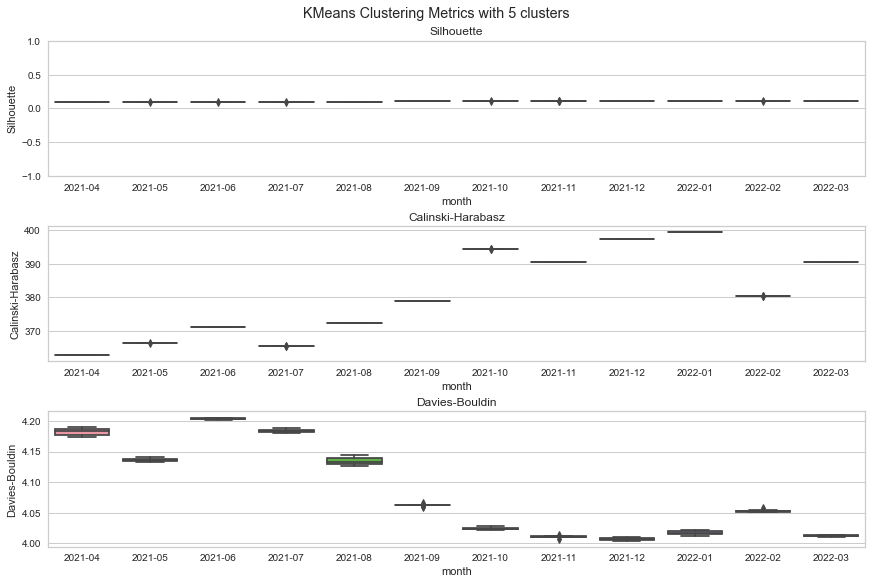

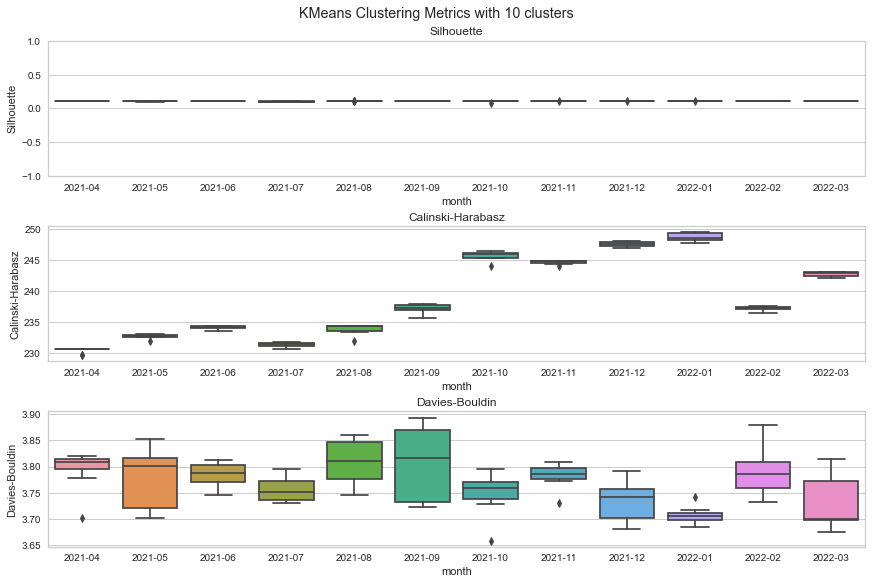

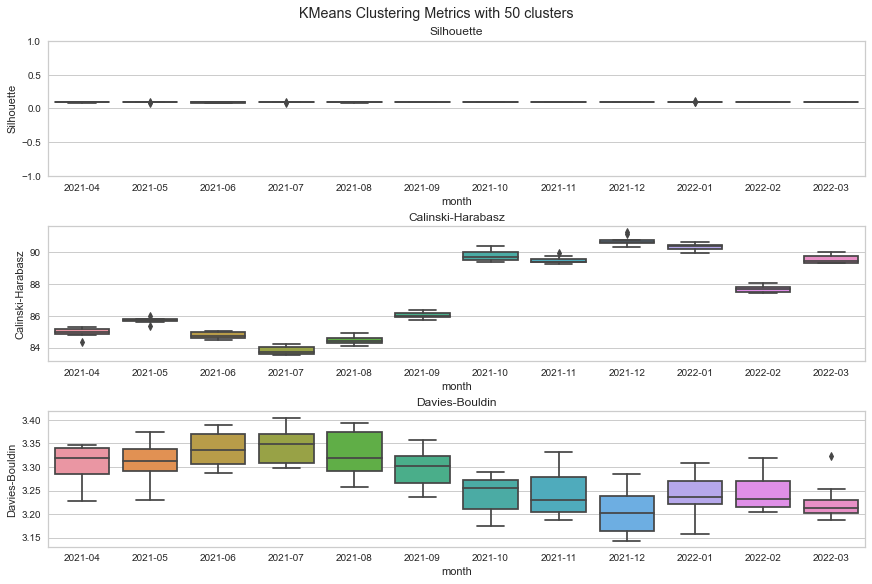

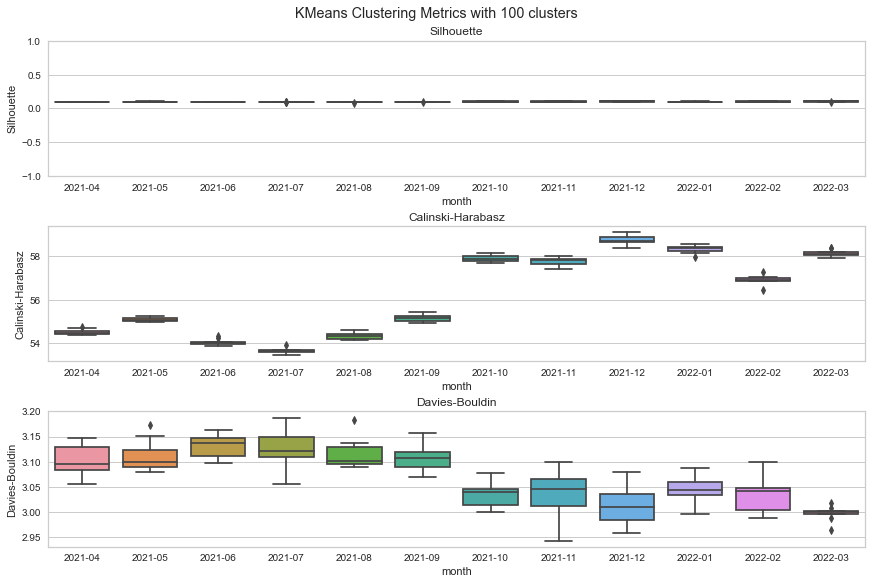

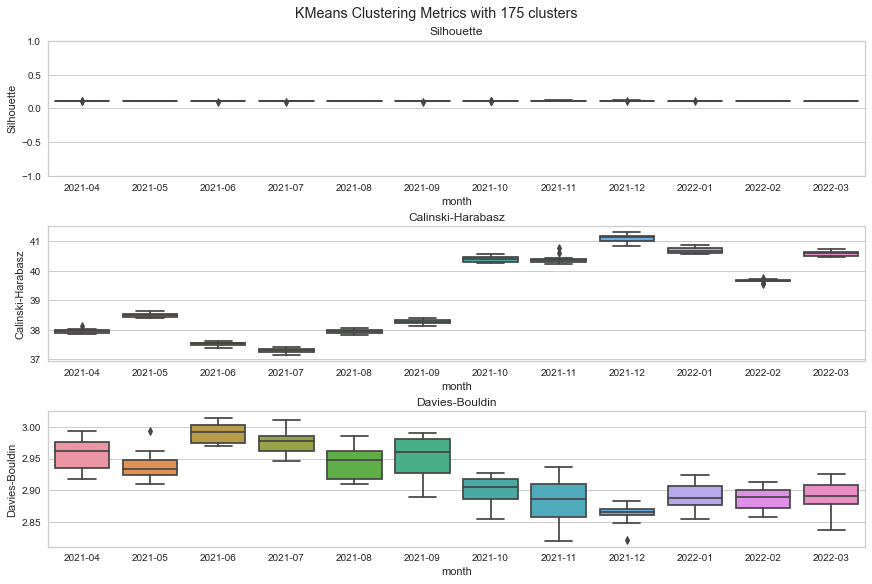

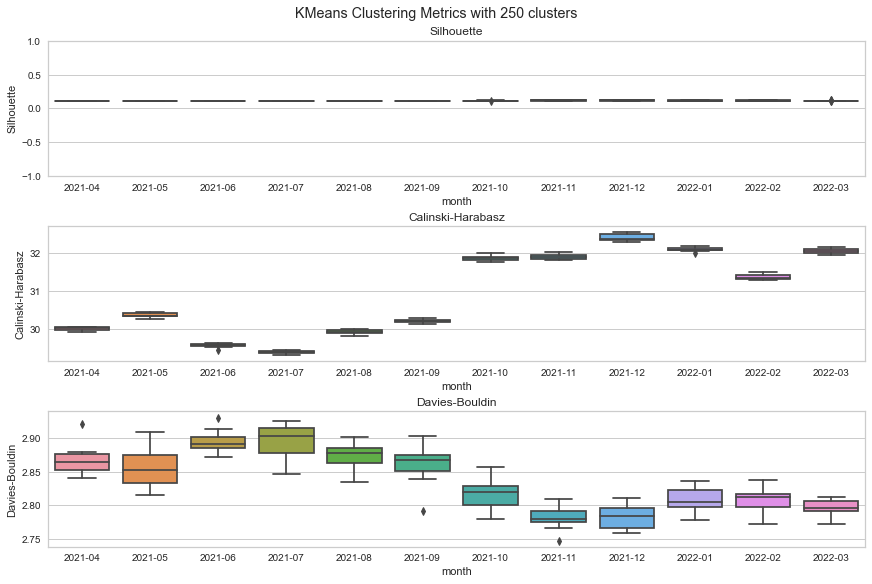

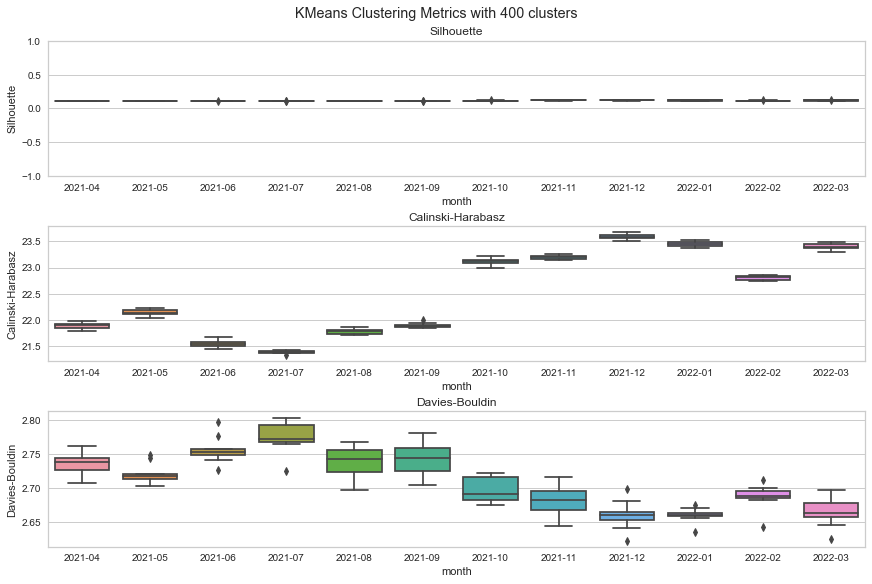

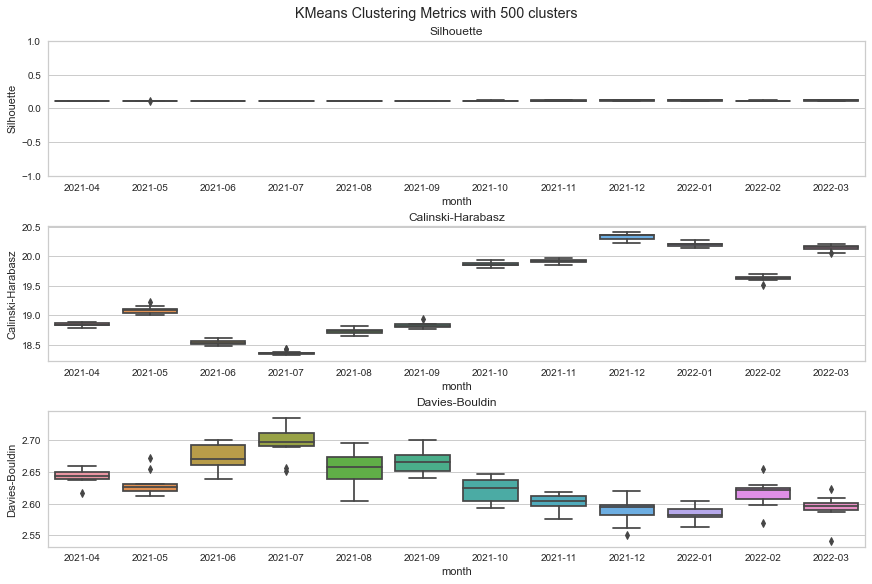

In [21]:
for n_clusters in NUM_CLUSTERS:
    fig, axes = plt.subplots(ncols = 1, nrows=3, figsize=(12,8), constrained_layout=True)
    fig.suptitle(f"KMeans Clustering Metrics with {n_clusters} clusters")
    num_clusters_df = kmeans_metrics_df[kmeans_metrics_df["n_clusters"]==n_clusters]
    for i, metric_key in enumerate(["Silhouette", "Calinski-Harabasz", "Davies-Bouldin"]):
        if metric_key=="Silhouette":
            axes[i].set(ylim=(-1, 1))
        sns.boxplot(ax = axes[i], x="month", y=metric_key, order=MONTHS, data=num_clusters_df)
        axes[i].set_title(metric_key)

In [3]:
# Pairwise comparison between KMeans cluster assignments of subreddits
all_comparison_results = []
comp_counter = 0
for n_clusters in NUM_CLUSTERS:
    print("Num clusters", n_clusters)
    # Compare month by month, experiment number i gets compared to all other experiments 
    # numbered i+1 or greater over all months
    for i1, month1 in enumerate(MONTHS):
        # Read in experiment 1 data
        month1_counts_dict = pd.read_csv(SUBREDDIT_COUNTS_CSVS[i1]).to_dict("records")
        month1_counts = {d["subreddit"]: d["count"] for d in month1_counts_dict}

        print("Month 1", month1, "Subreddit check", len(month1_counts))
        for exp_id1, seed in enumerate(RANDOM_SEEDS): 
            current_kmeans_path = STABILITY_METRICS_ROOT / f"{month1}" / f"{month1}_numClusters{n_clusters}" / str(exp_id1)
            current_kmeans_model = ic.ClusteringModel.load(current_kmeans_path, 
                C2V_MODELS[i1].get_normed_vectors(),
                C2V_MODELS[i1].get_index_to_key(),
            )
            current_model_assignments = {subreddit: current_kmeans_model.clusters[position] for position, subreddit in enumerate(current_kmeans_model.index_to_key)}

            # Read in experiment 2 data
            for i2, month2 in enumerate(MONTHS):
                month2_counts_dict = pd.read_csv(SUBREDDIT_COUNTS_CSVS[i2]).to_dict("records")
                month2_counts = {d["subreddit"]: d["count"] for d in month2_counts_dict}
                for exp_id2 in range(exp_id1 + 1, len(RANDOM_SEEDS)):
                    kmeans_comparison_path = STABILITY_METRICS_ROOT / f"{month2}" / f"{month2}_numClusters{n_clusters}" / str(exp_id2)
                    kmeans_comparison_model = ic.ClusteringModel.load(
                        kmeans_comparison_path, 
                        C2V_MODELS[i2].get_normed_vectors(),
                        C2V_MODELS[i2].get_index_to_key()
                        )
                    comparison_model_assignments = {subreddit: kmeans_comparison_model.clusters[position] for position, subreddit in enumerate(kmeans_comparison_model.index_to_key)}

                    # Compare the experiments and collect results
                    comparison_results = {"n_clusters":n_clusters, "month1": month1, "month1_experiment_id": exp_id1, "month2":month2, "month2_experiment_id":exp_id2 }
                    intersection_comparison_results = ic.compare_cluterings(current_model_assignments, comparison_model_assignments, use_union=False,
                    cluster_1_counts = month1_counts, 
                    cluster_2_counts = month2_counts)
                    comparison_results.update(intersection_comparison_results)

                    intersection_uniform_prob_results = ic.compare_cluterings(current_model_assignments, comparison_model_assignments, use_union=False)
                    comparison_results.update(intersection_uniform_prob_results)

                    union_comparison_results = ic.compare_cluterings(current_model_assignments, comparison_model_assignments, use_union=True,
                    cluster_1_counts = month1_counts, 
                    cluster_2_counts = month2_counts)
                    comparison_results.update(union_comparison_results)

                    all_comparison_results.append(comparison_results)
                    comp_counter+=1
                    if comp_counter % 100 ==0:
                        print("Comparisons complete:", comp_counter)

cluster_comparison_df = pd.DataFrame.from_records(all_comparison_results)
display(cluster_comparison_df)




Num clusters 5
Month 1 2021-04 Subreddit check 10000
Comparisons complete: 100
Comparisons complete: 200
Comparisons complete: 300
Comparisons complete: 400
Comparisons complete: 500
Month 1 2021-05 Subreddit check 10000
Comparisons complete: 600
Comparisons complete: 700
Comparisons complete: 800
Comparisons complete: 900
Comparisons complete: 1000
Month 1 2021-06 Subreddit check 10000
Comparisons complete: 1100
Comparisons complete: 1200
Comparisons complete: 1300
Comparisons complete: 1400
Comparisons complete: 1500
Comparisons complete: 1600
Month 1 2021-07 Subreddit check 10000
Comparisons complete: 1700
Comparisons complete: 1800
Comparisons complete: 1900
Comparisons complete: 2000
Comparisons complete: 2100
Month 1 2021-08 Subreddit check 10000
Comparisons complete: 2200
Comparisons complete: 2300
Comparisons complete: 2400
Comparisons complete: 2500
Comparisons complete: 2600
Comparisons complete: 2700
Month 1 2021-09 Subreddit check 10000
Comparisons complete: 2800
Comparison

n_clusters   month1  month1_experiment_id   month2  \
0               5  2021-04                     0  2021-04   
1               5  2021-04                     0  2021-04   
2               5  2021-04                     0  2021-04   
3               5  2021-04                     0  2021-04   
4               5  2021-04                     0  2021-04   
...           ...      ...                   ...      ...   
51835         500  2022-03                     8  2021-11   
51836         500  2022-03                     8  2021-12   
51837         500  2022-03                     8  2022-01   
51838         500  2022-03                     8  2022-02   
51839         500  2022-03                     8  2022-03   

       month2_experiment_id  \
0                         1   
1                         2   
2                         3   
3                         4   
4                         5   
...                     ...   
51835                     9   
51836                     9   
51837                     9   
51838                     9   
51839                     9   

       intersection_comment_probability_variation_of_information  \
0                                               0.092085           
1                                               0.103310           
2                                               0.072029           
3                                               0.075428           
4                                               0.199457           
...                                                  ...           
51835                                           1.742801           
51836                                           1.854449           
51837                                           1.933053           
51838                                           1.992782           
51839                                           1.737303           

       intersection_uniform_probability_adjusted_rand_index  \
0                                               0.968100      
1                                               0.962305      
2                                               0.971900      
3                                               0.970839      
4                                               0.950144      
...                                                  ...      
51835                                           0.478719      
51836                                           0.451317      
51837                                           0.438977      
51838                                           0.463970      
51839                                           0.527389      

       intersection_uniform_probability_rand_index  \
0                                         0.989449   
1                                         0.987535   
2                                         0.990709   
3                                         0.990359   
4                                         0.983516   
...                                            ...   
51835                                     0.997335   
51836                                     0.997150   
51837                                     0.997213   
51838                                     0.997292   
51839                                     0.997556   

       intersection_uniform_probability_normalized_mutual_info  \
0                                               0.958835         
1                                               0.951389         
2                                               0.962689         
3                                               0.960214         
4                                               0.937593         
...                                                  ...         
51835                                           0.835790         
51836                                           0.832405         
51837                                           0.830007         
51838             

In [4]:
cluster_comparison_df.to_csv(STABILITY_METRICS_ROOT / "cluster_comparison_metrics.csv", index=False)

In [3]:
cluster_comparison_df = pd.read_csv(STABILITY_METRICS_ROOT / "cluster_comparison_metrics.csv")
display(cluster_comparison_df)

n_clusters   month1  month1_experiment_id   month2  \
0               5  2021-04                     0  2021-04   
1               5  2021-04                     0  2021-04   
2               5  2021-04                     0  2021-04   
3               5  2021-04                     0  2021-04   
4               5  2021-04                     0  2021-04   
...           ...      ...                   ...      ...   
51835         500  2022-03                     8  2021-11   
51836         500  2022-03                     8  2021-12   
51837         500  2022-03                     8  2022-01   
51838         500  2022-03                     8  2022-02   
51839         500  2022-03                     8  2022-03   

       month2_experiment_id  \
0                         1   
1                         2   
2                         3   
3                         4   
4                         5   
...                     ...   
51835                     9   
51836                     9   
51837                     9   
51838                     9   
51839                     9   

       intersection_comment_probability_variation_of_information  \
0                                               0.092085           
1                                               0.103310           
2                                               0.072029           
3                                               0.075428           
4                                               0.199457           
...                                                  ...           
51835                                           1.742801           
51836                                           1.854449           
51837                                           1.933053           
51838                                           1.992782           
51839                                           1.737303           

       intersection_uniform_probability_adjusted_rand_index  \
0                                               0.968100      
1                                               0.962305      
2                                               0.971900      
3                                               0.970839      
4                                               0.950144      
...                                                  ...      
51835                                           0.478719      
51836                                           0.451317      
51837                                           0.438977      
51838                                           0.463970      
51839                                           0.527389      

       intersection_uniform_probability_rand_index  \
0                                         0.989449   
1                                         0.987535   
2                                         0.990709   
3                                         0.990359   
4                                         0.983516   
...                                            ...   
51835                                     0.997335   
51836                                     0.997150   
51837                                     0.997213   
51838                                     0.997292   
51839                                     0.997556   

       intersection_uniform_probability_normalized_mutual_info  \
0                                               0.958835         
1                                               0.951389         
2                                               0.962689         
3                                               0.960214         
4                                               0.937593         
...                                                  ...         
51835                                           0.835790         
51836                                           0.832405         
51837                                           0.830007         
51838             

Num clusters: 5


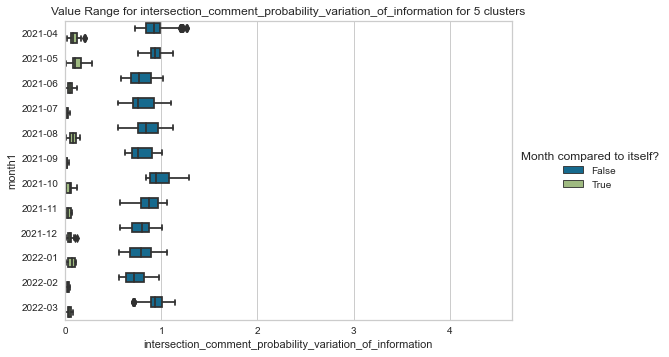

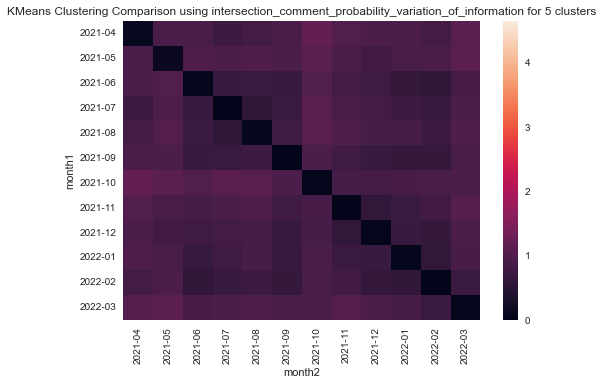

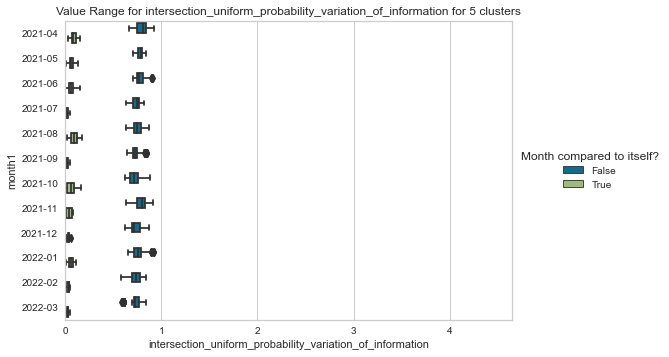

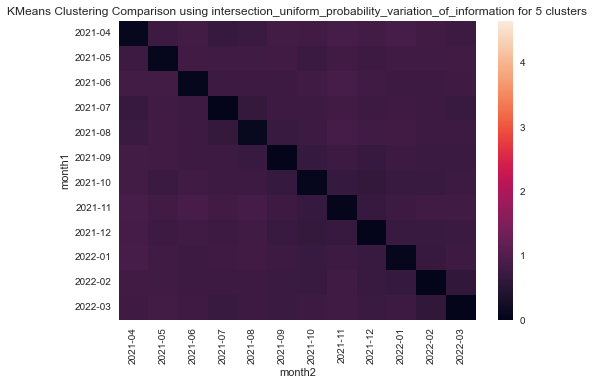

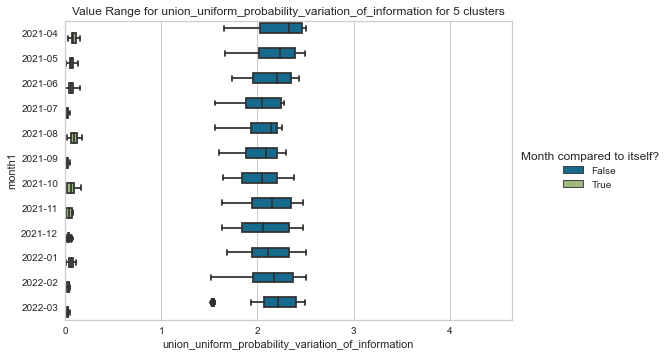

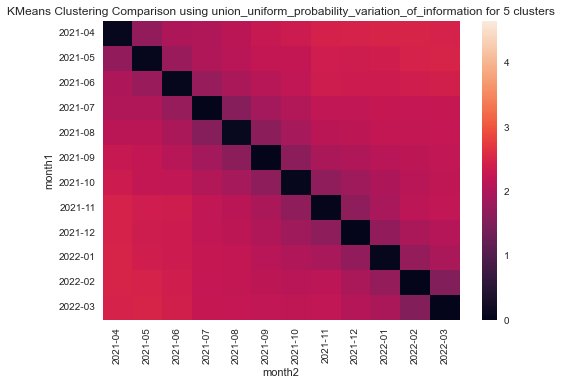

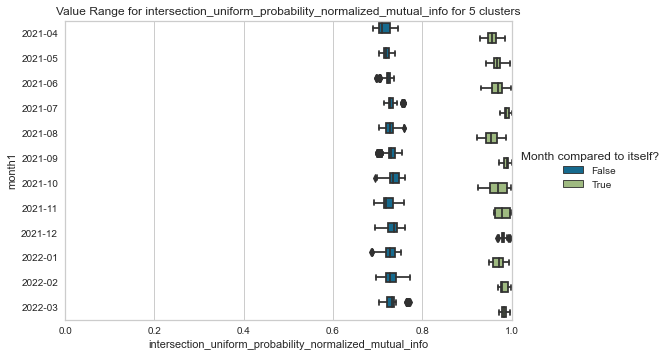

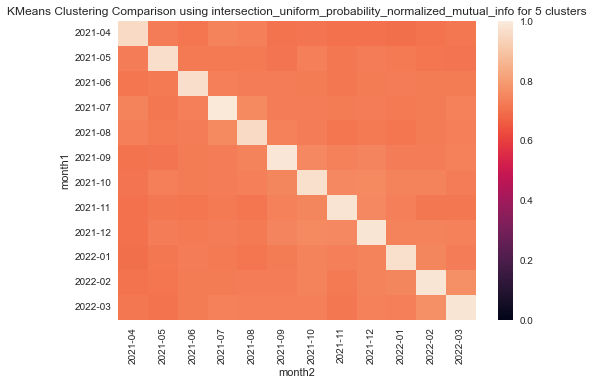

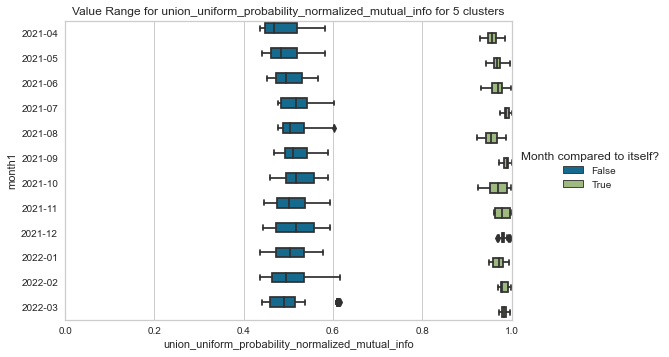

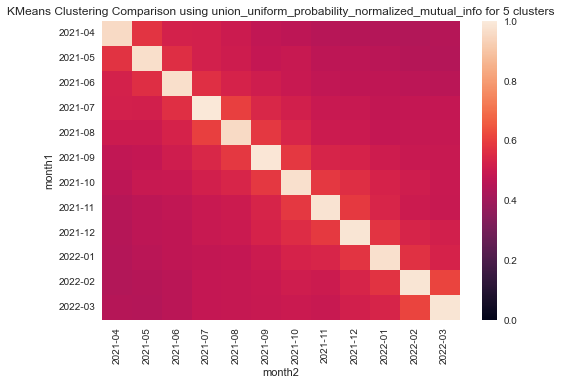

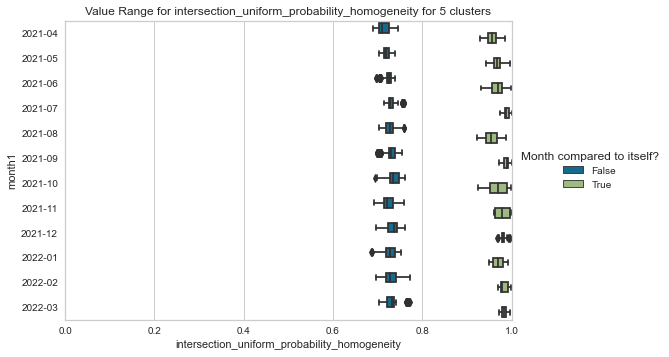

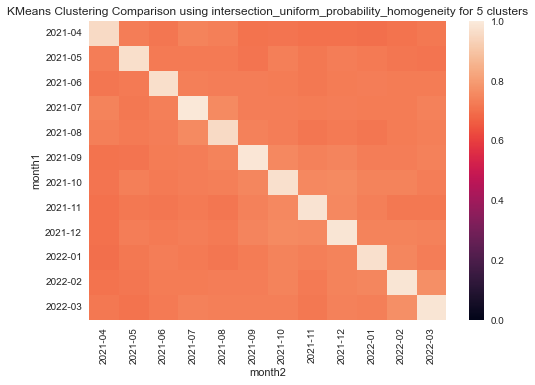

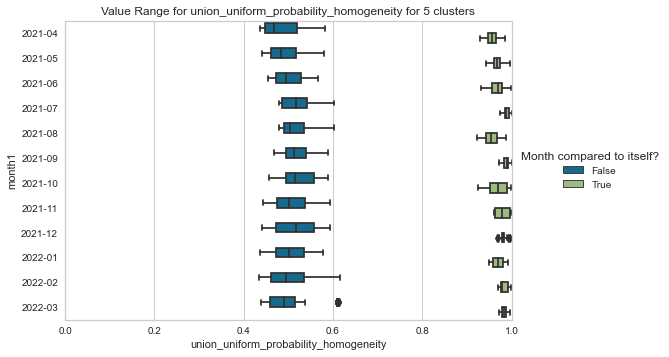

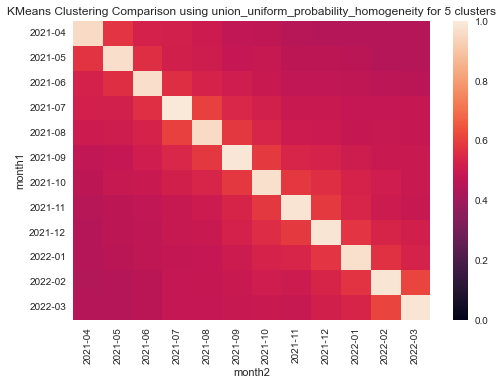

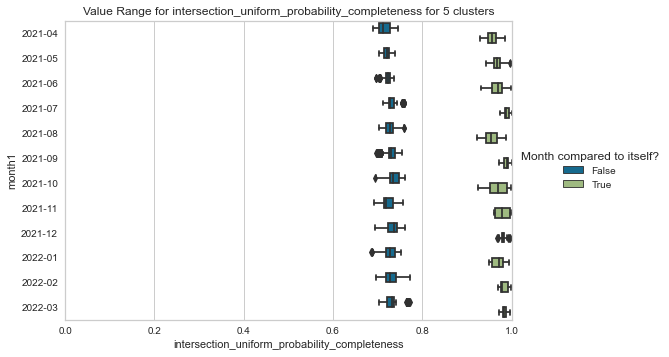

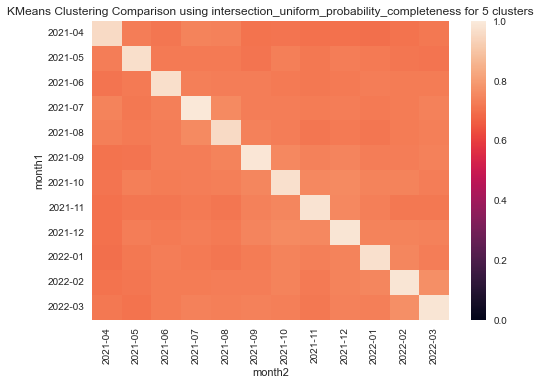

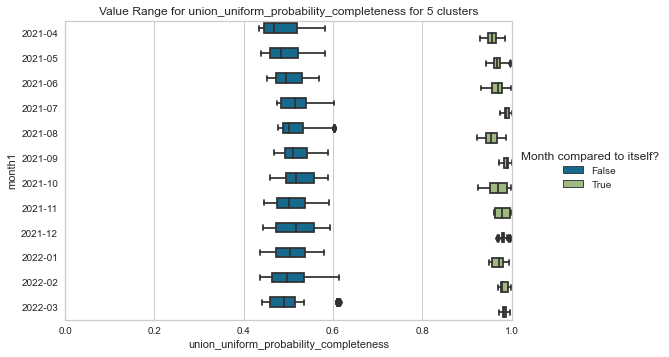

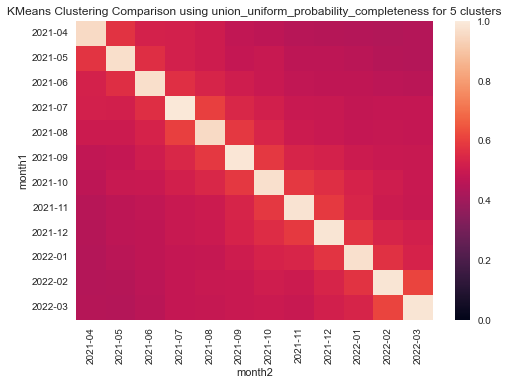

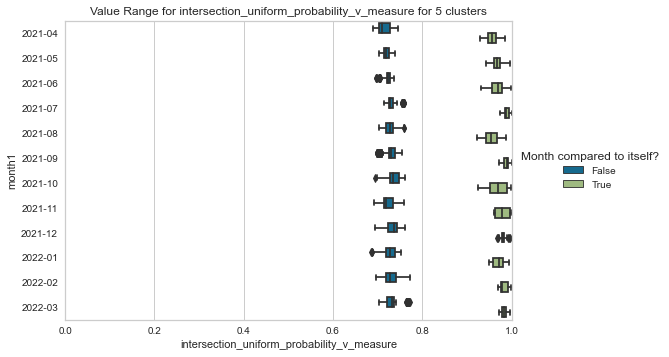

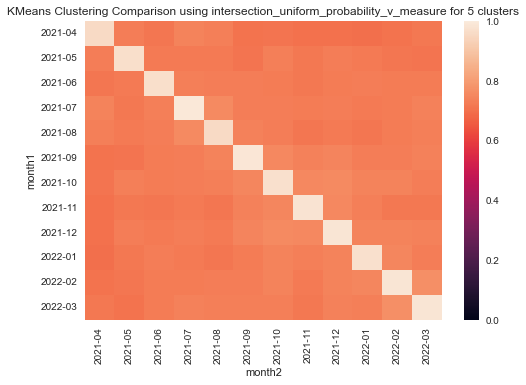

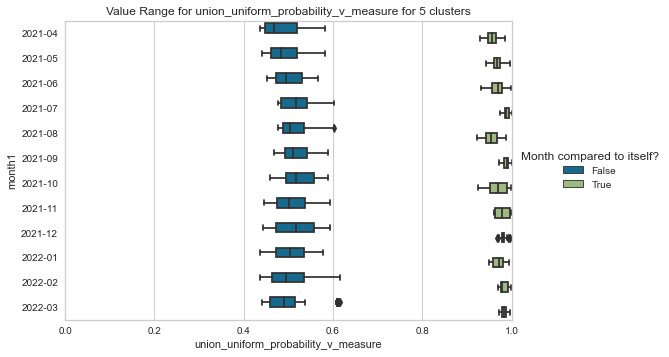

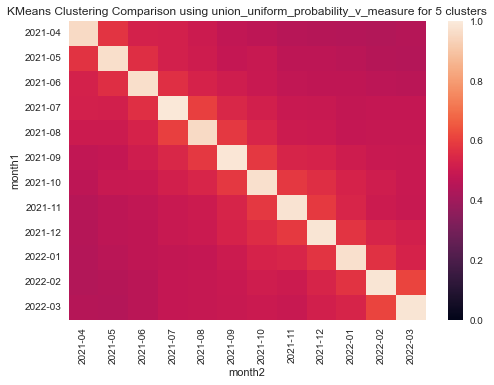

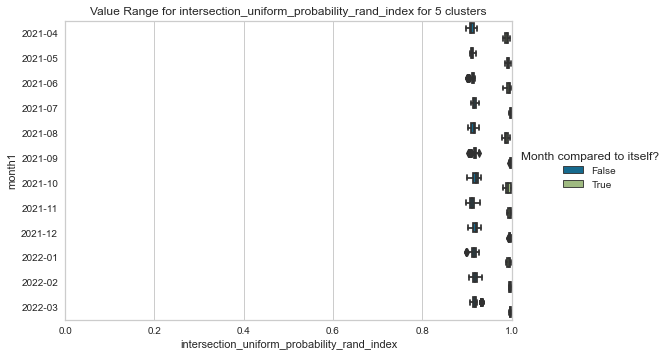

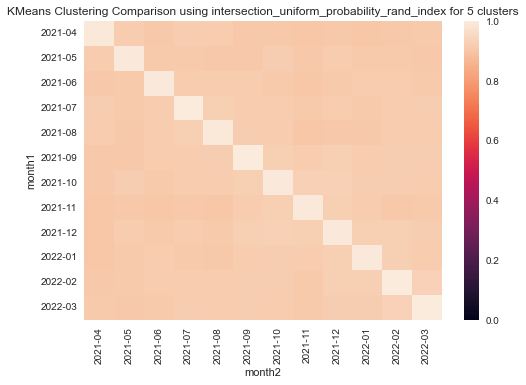

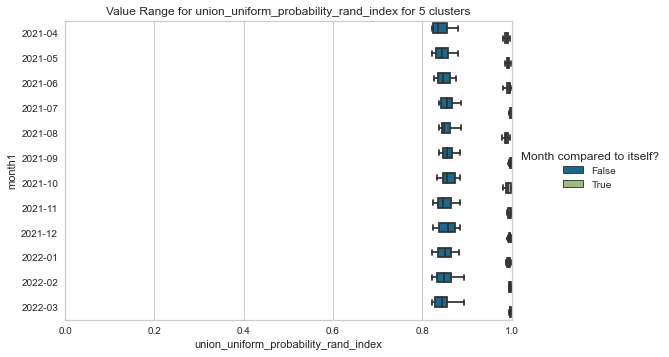

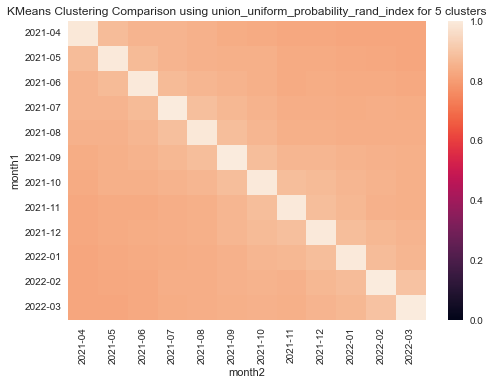

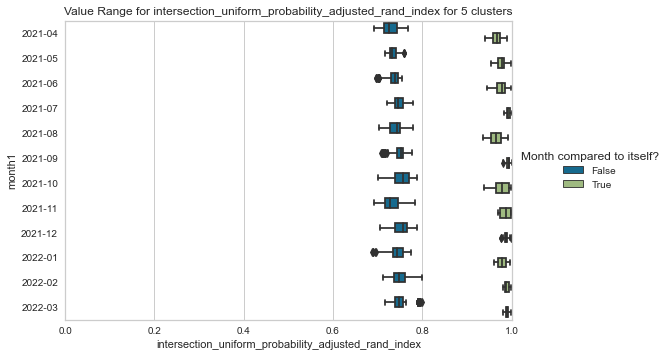

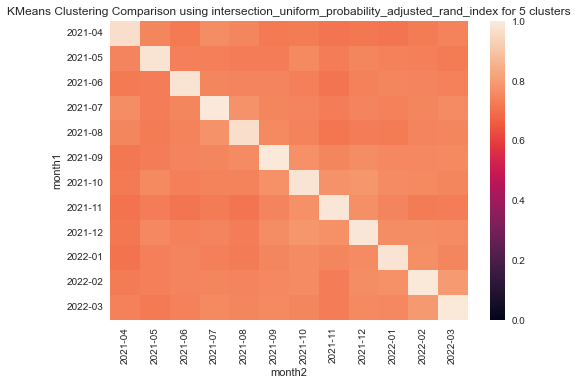

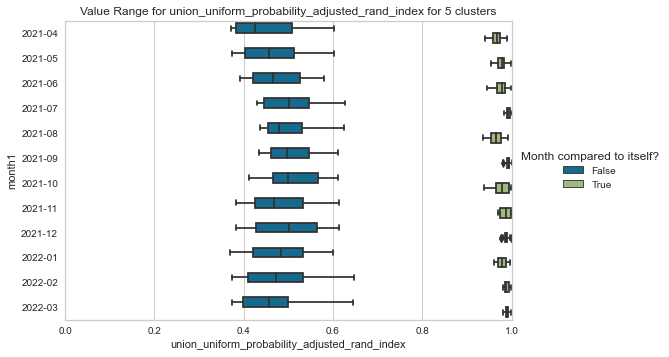

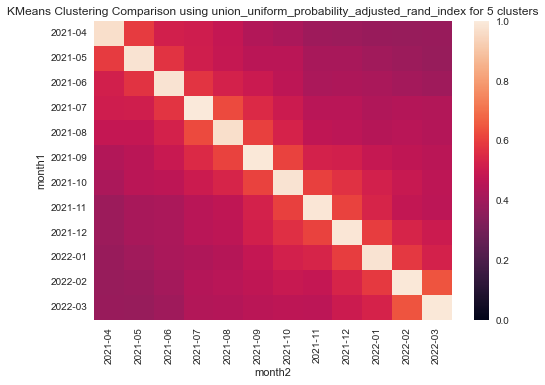

Num clusters: 10


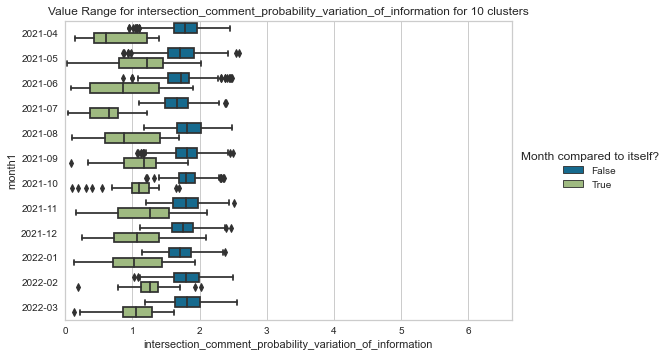

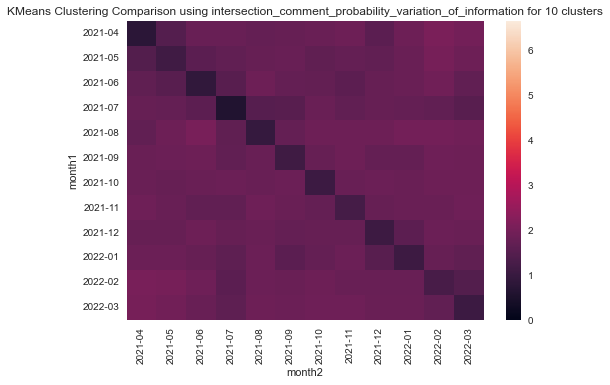

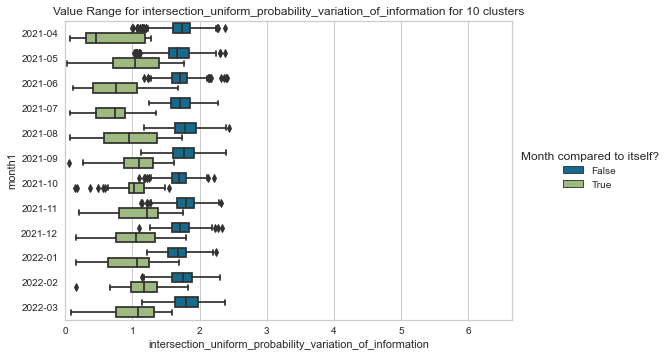

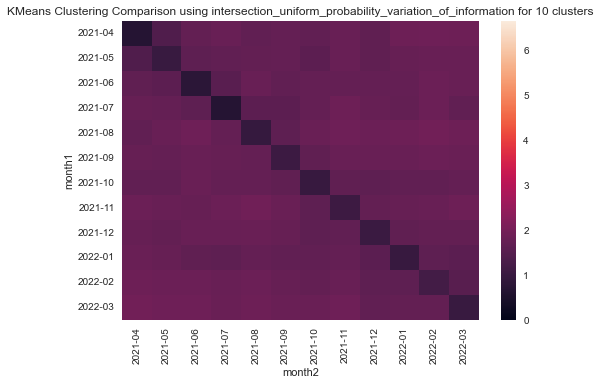

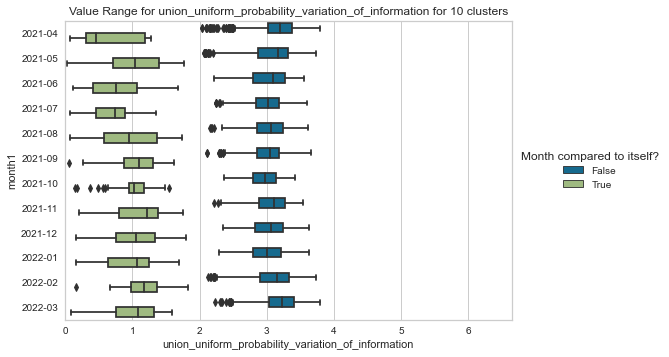

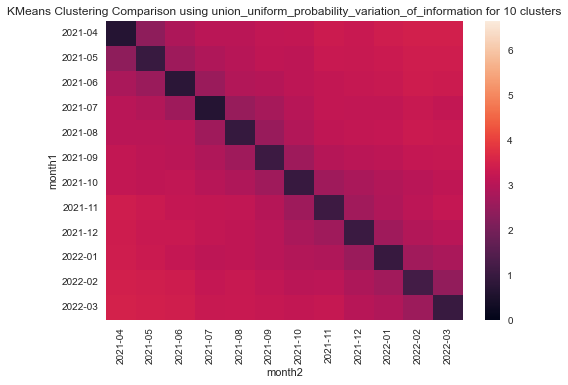

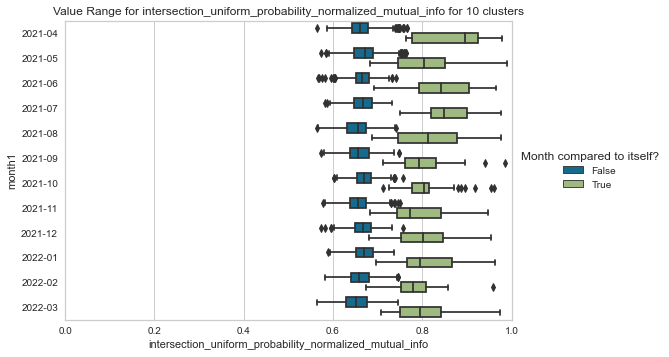

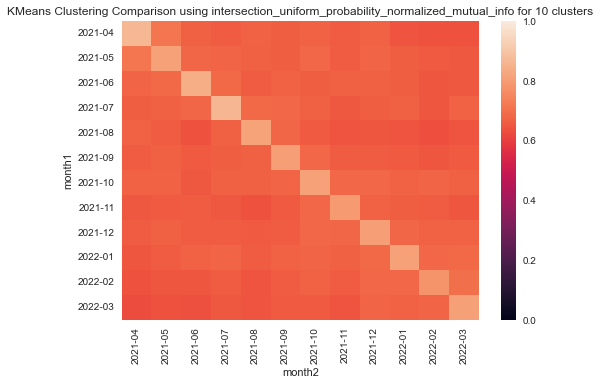

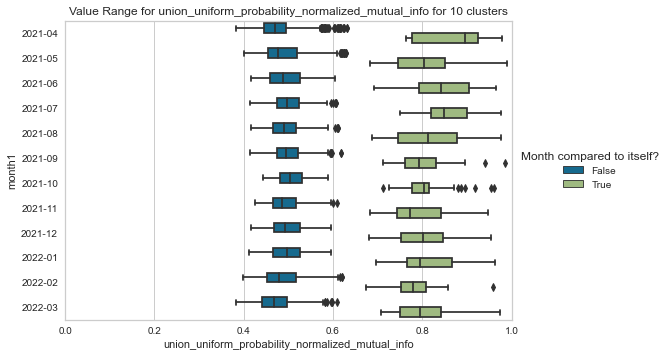

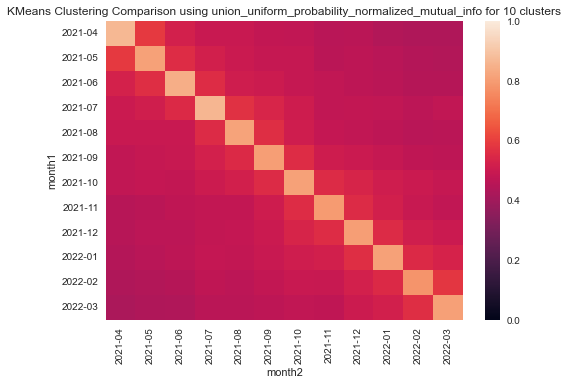

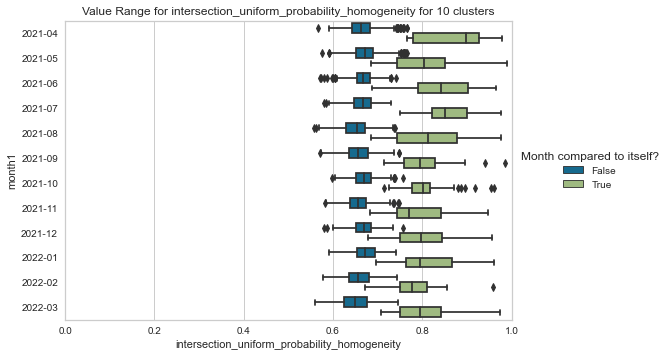

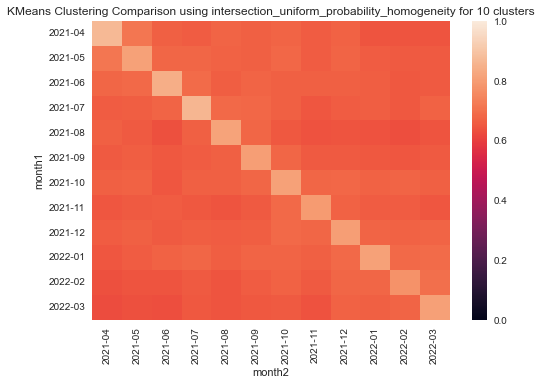

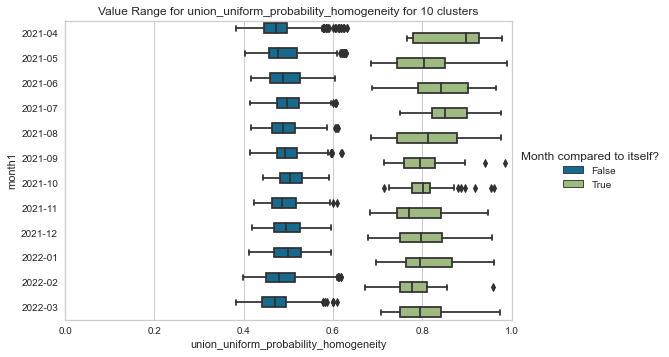

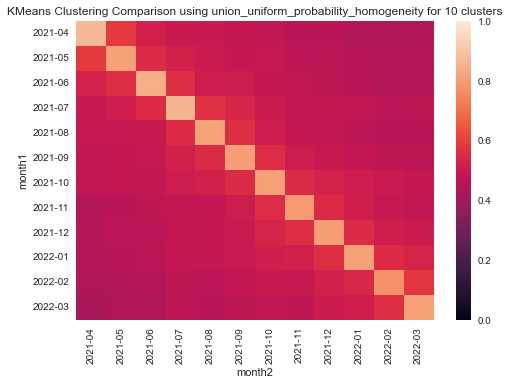

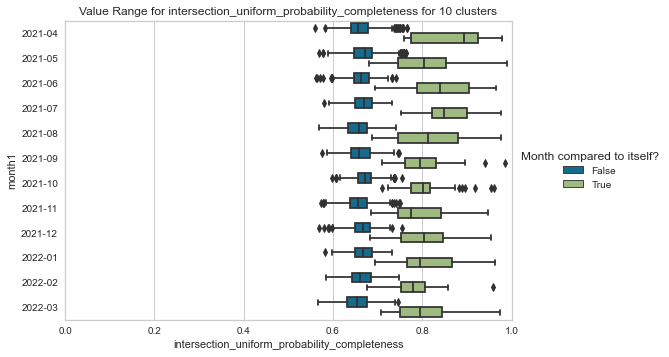

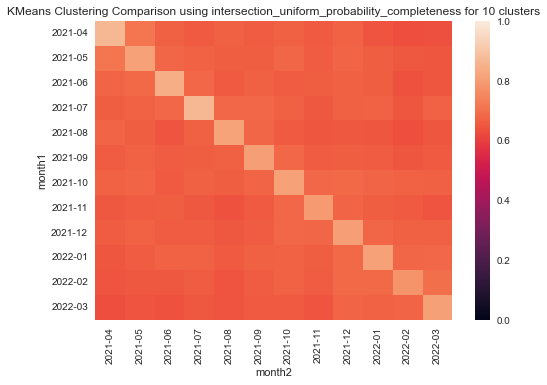

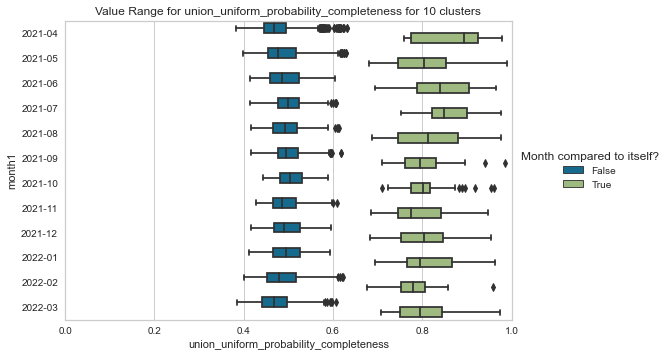

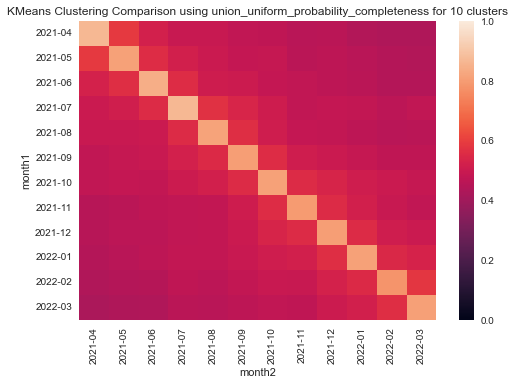

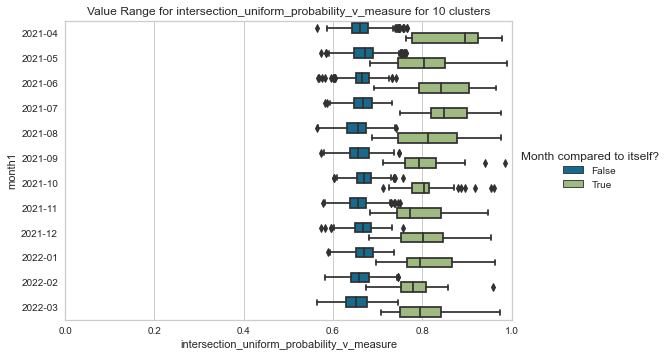

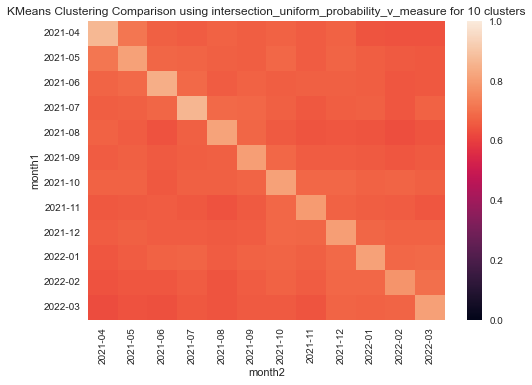

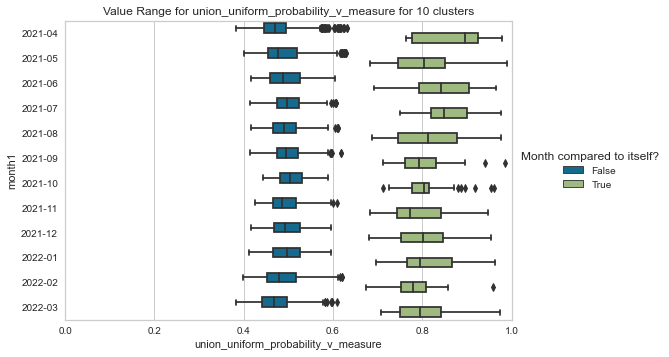

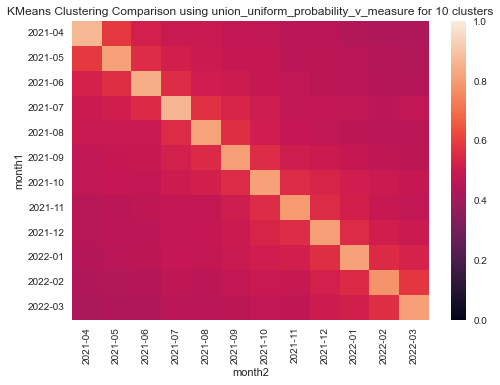

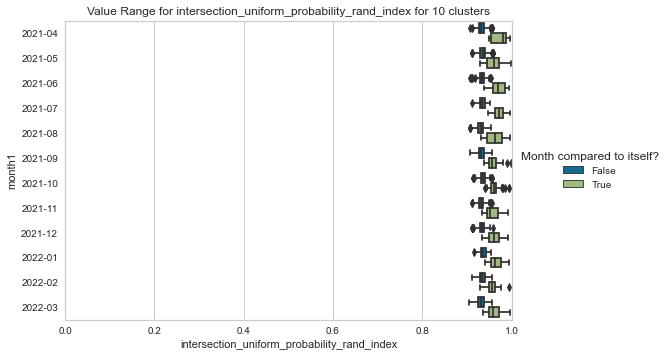

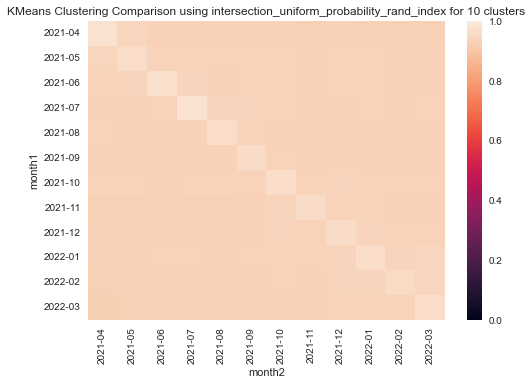

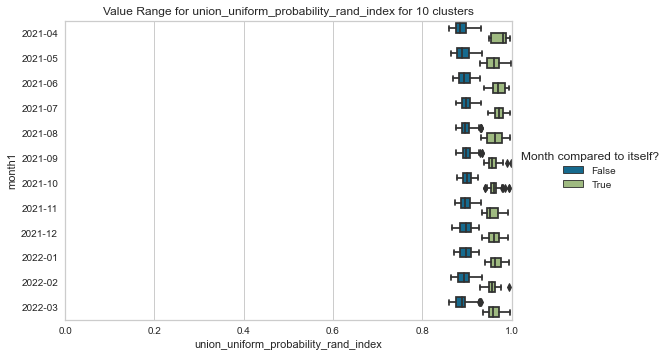

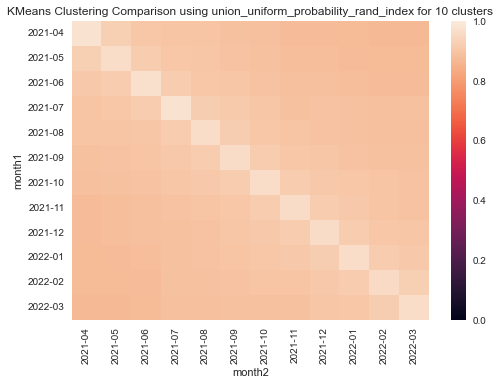

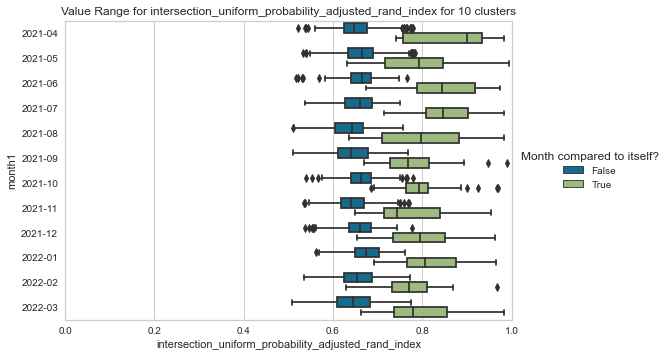

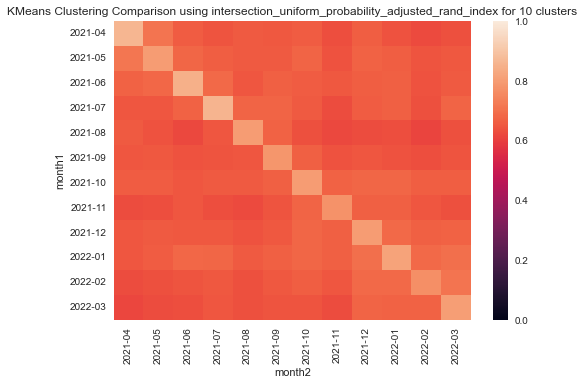

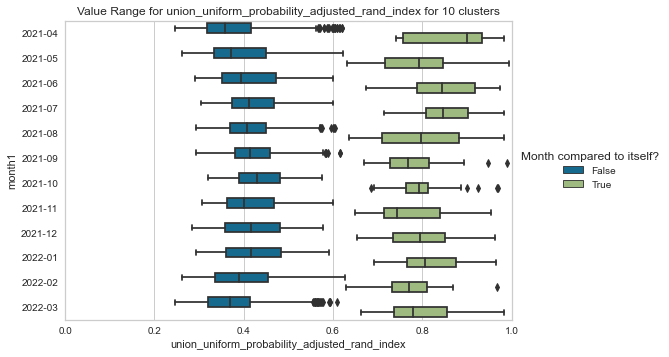

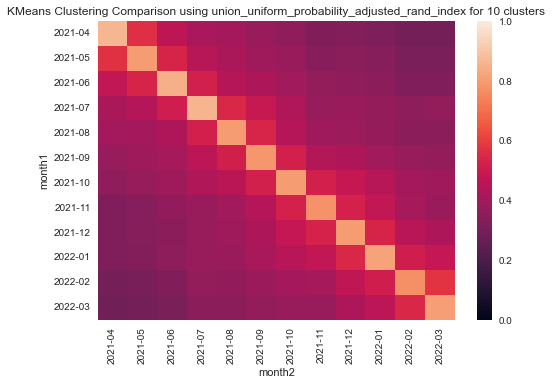

Num clusters: 50


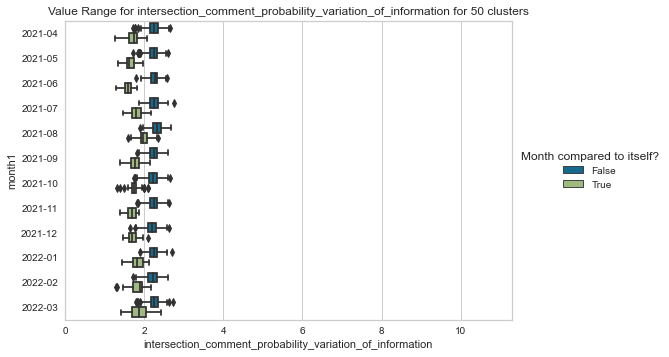

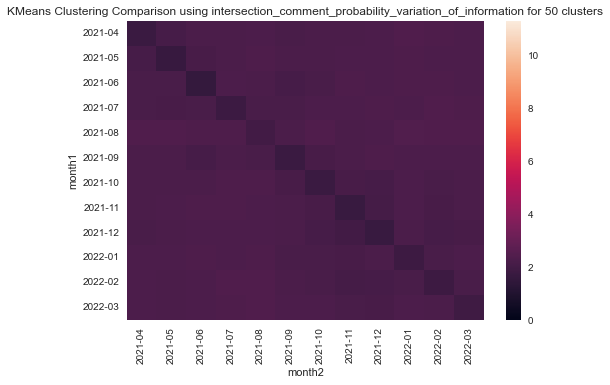

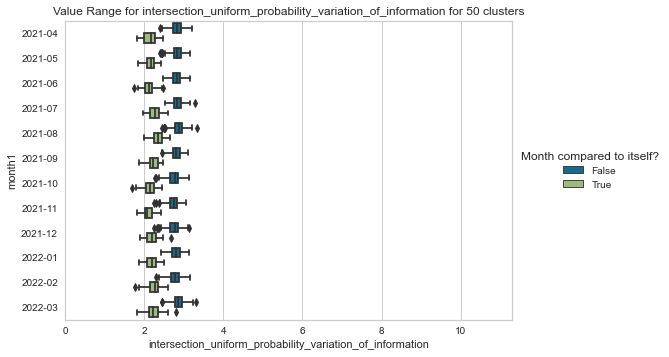

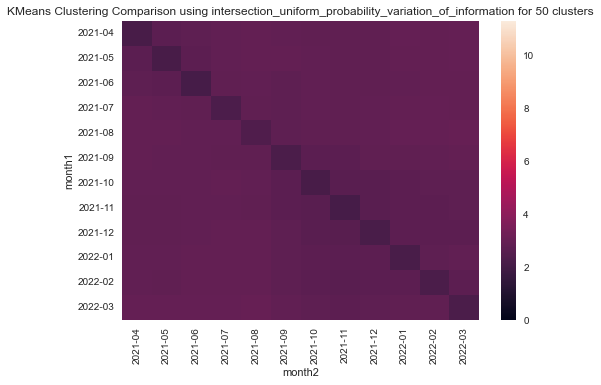

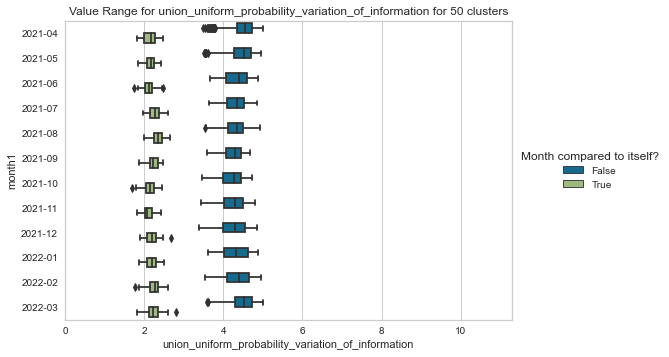

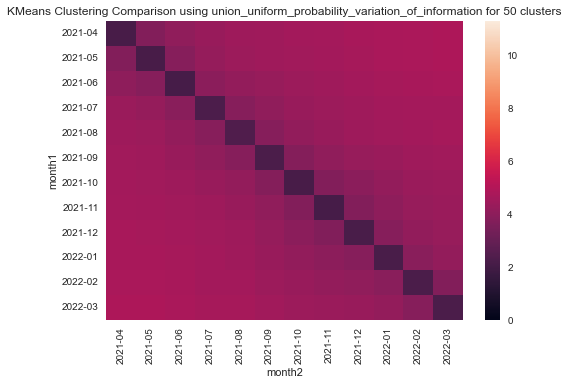

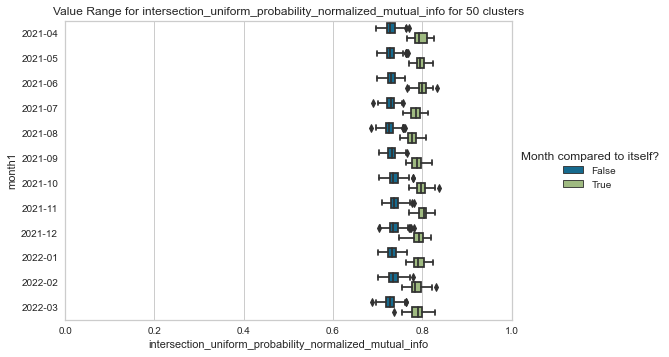

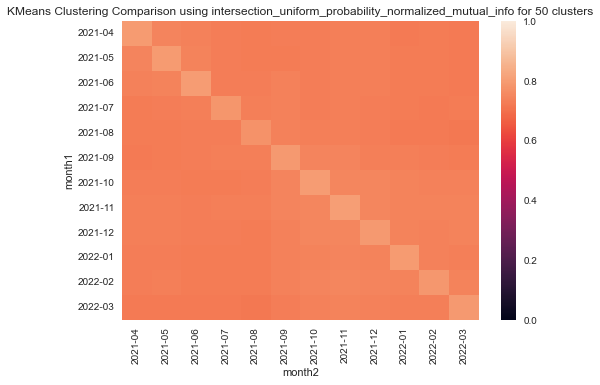

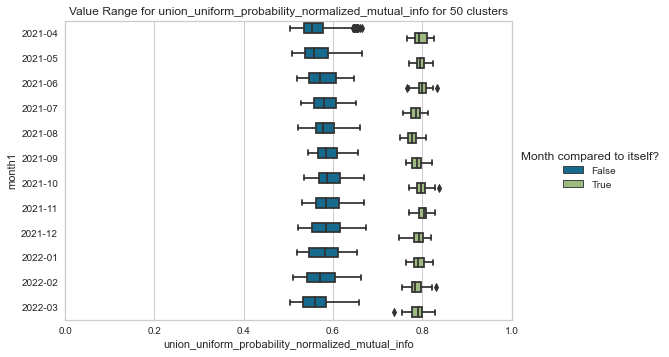

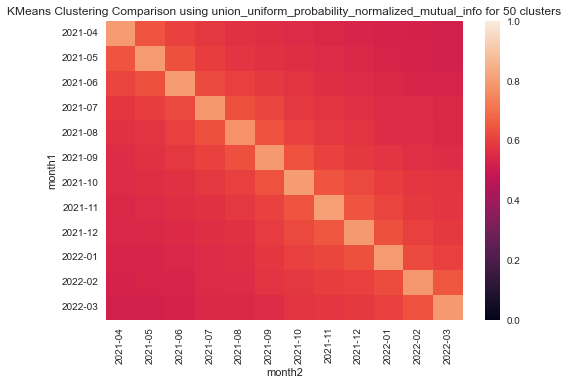

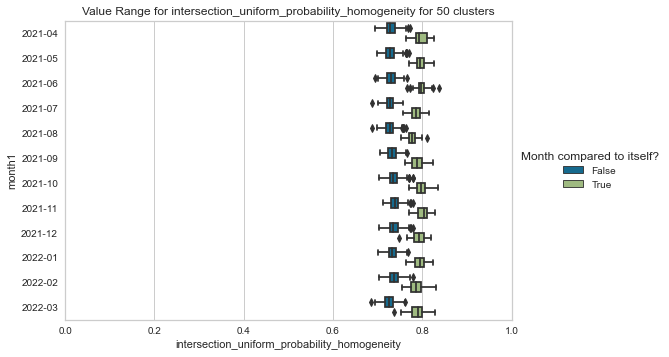

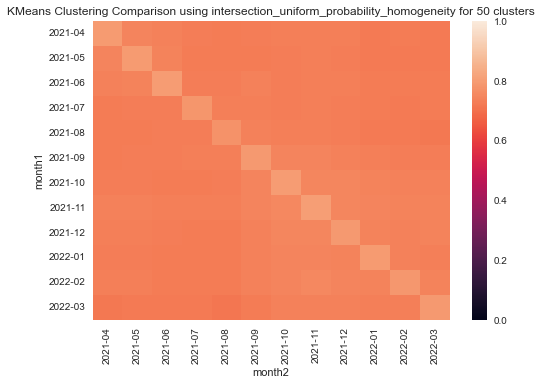

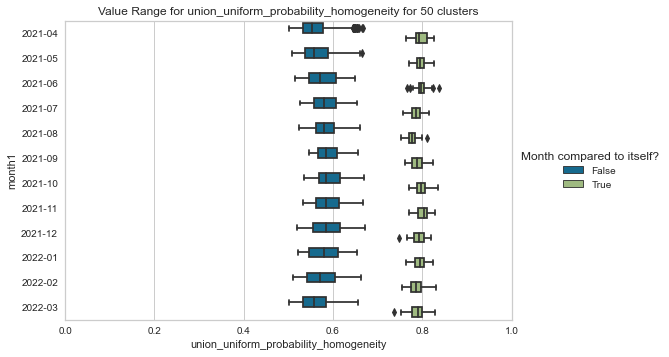

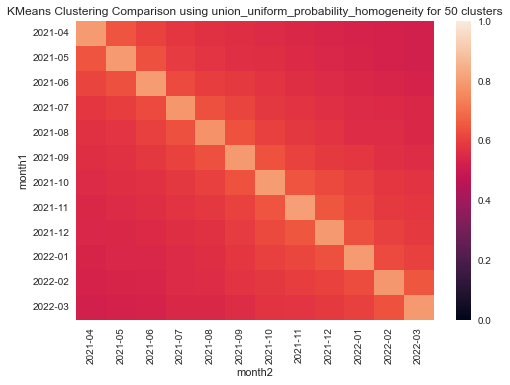

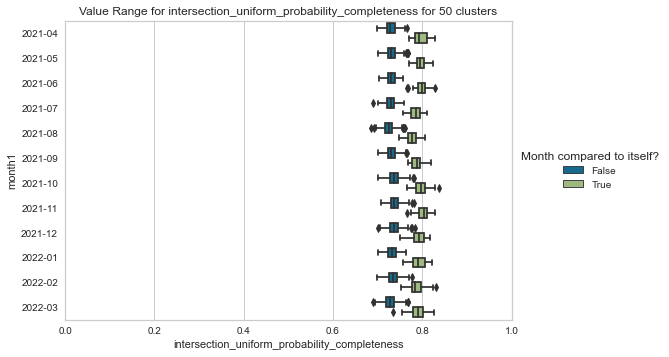

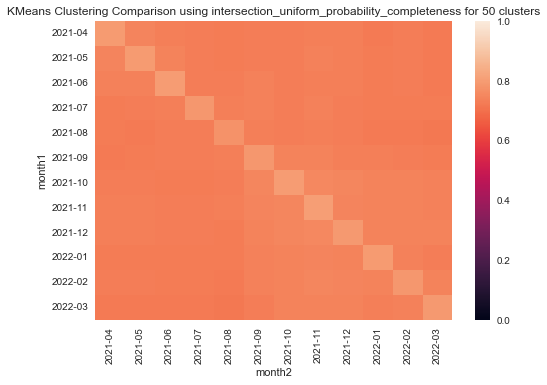

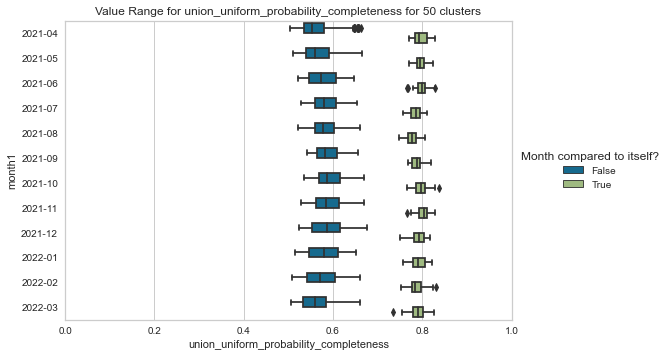

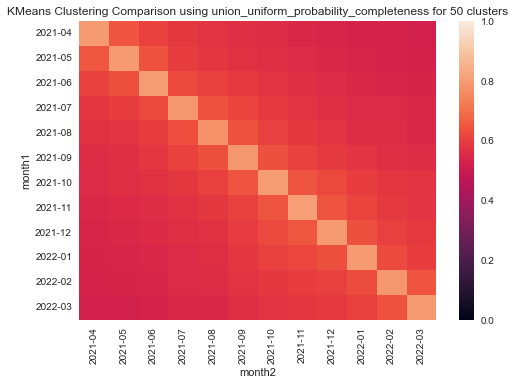

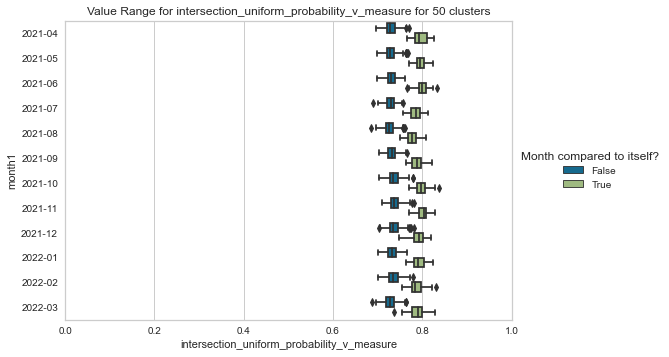

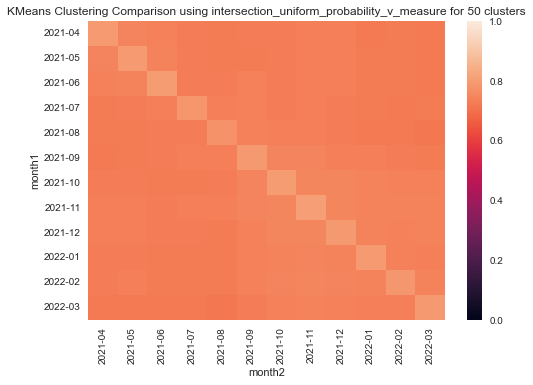

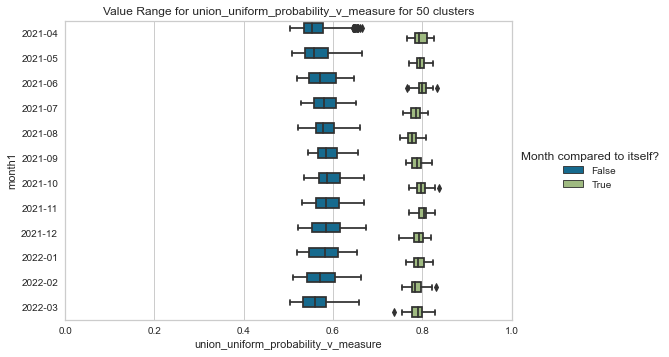

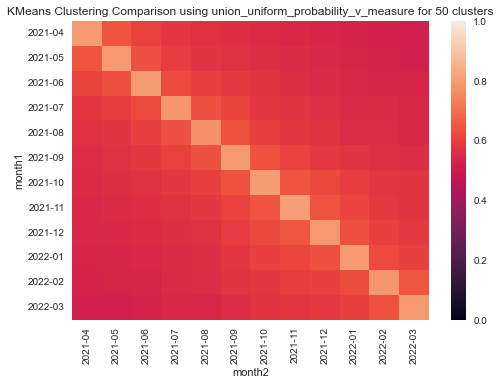

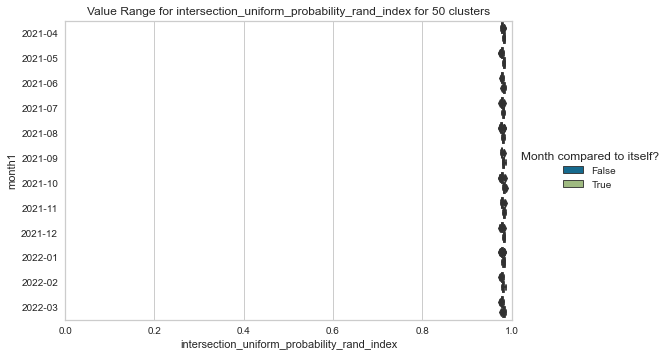

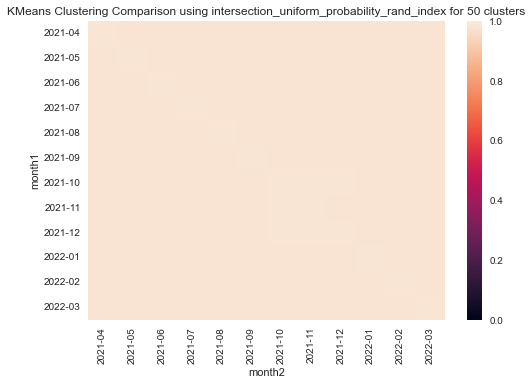

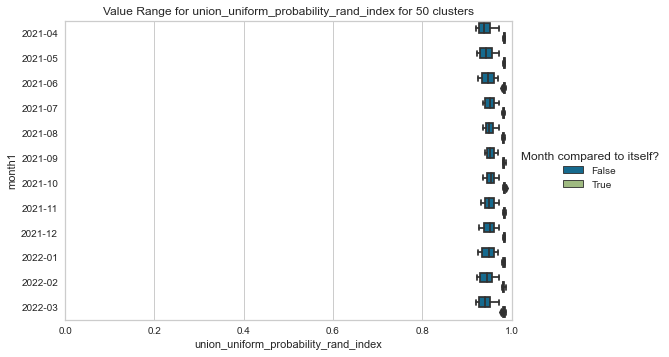

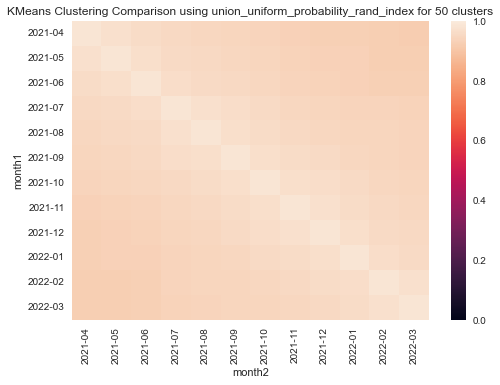

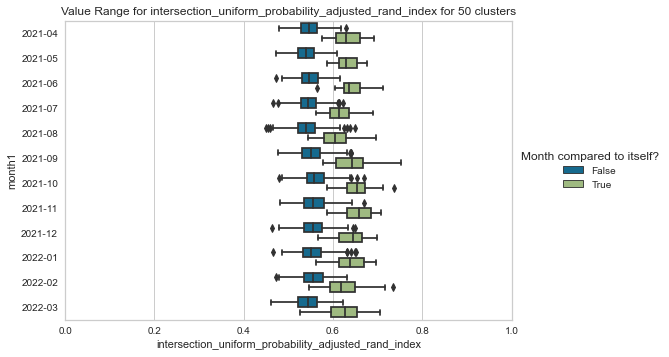

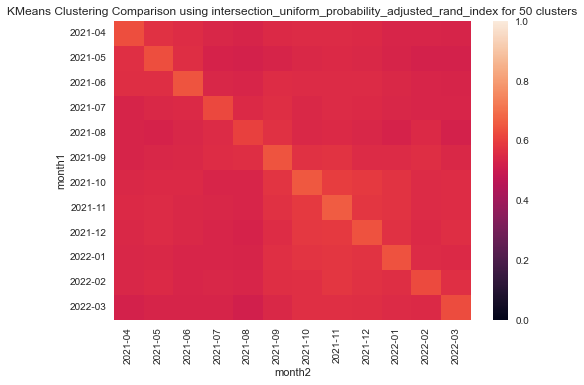

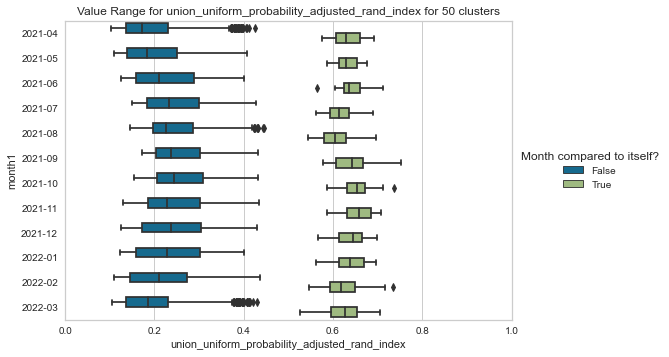

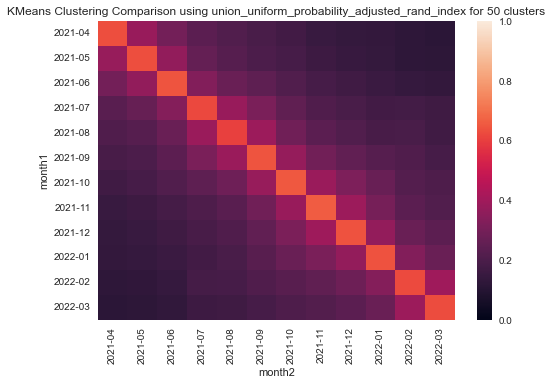

Num clusters: 100


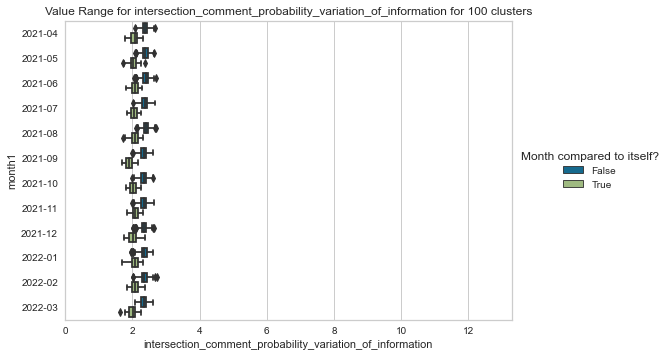

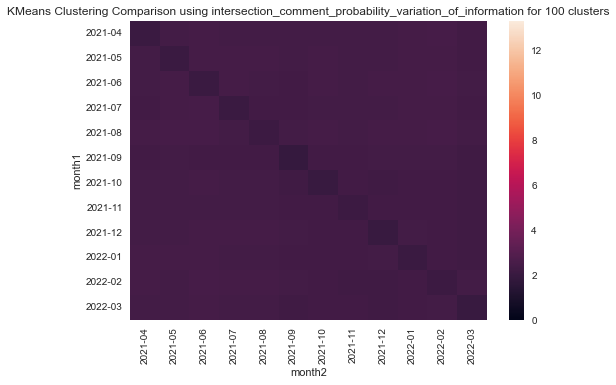

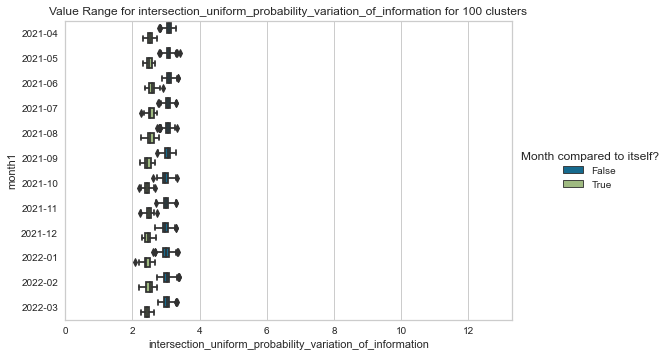

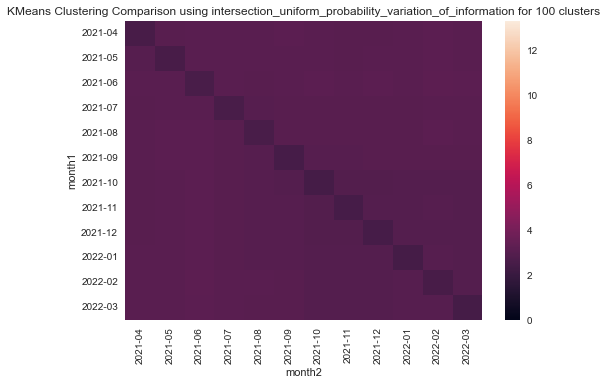

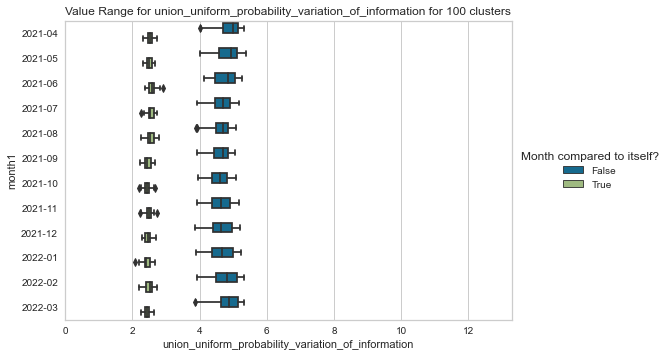

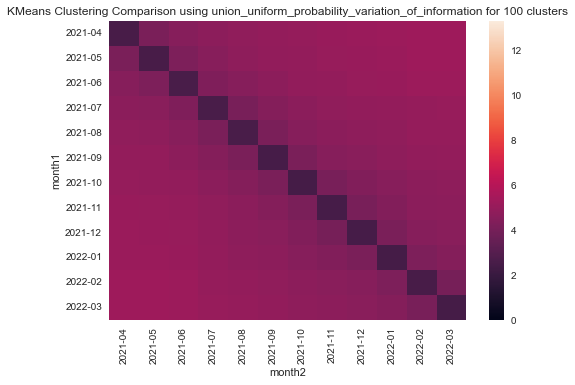

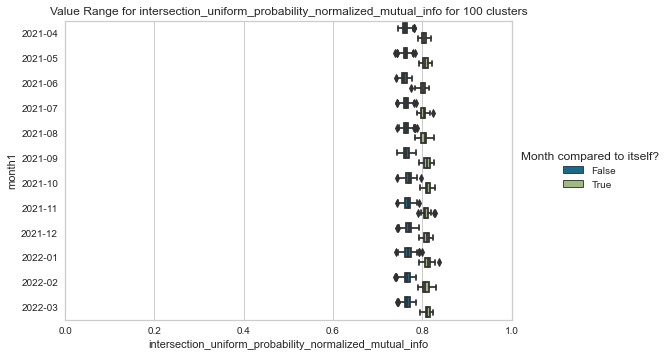

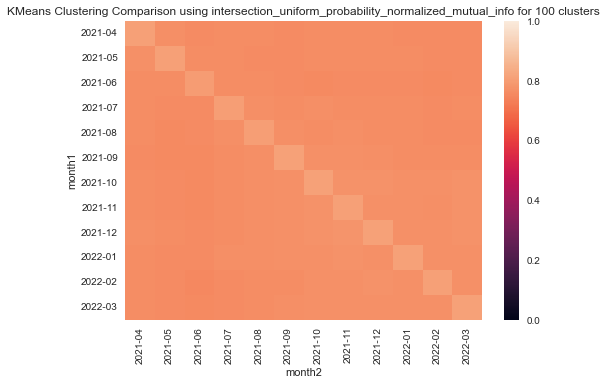

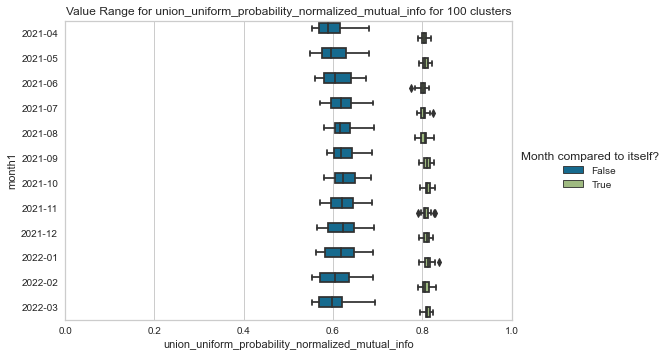

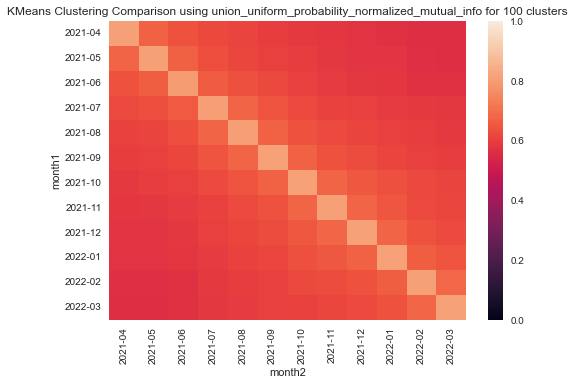

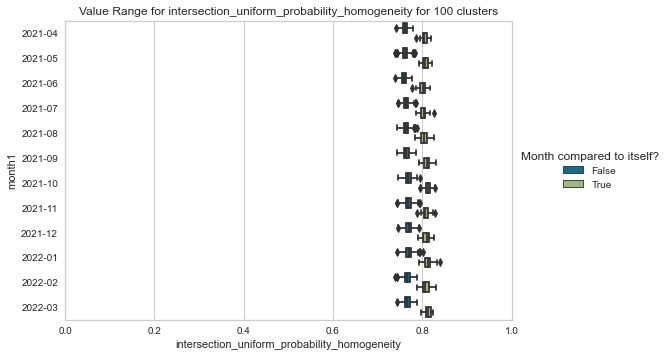

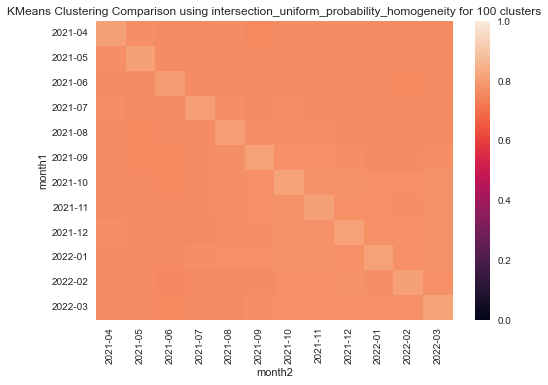

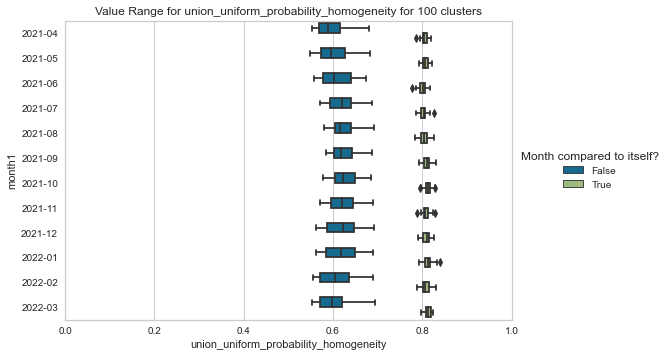

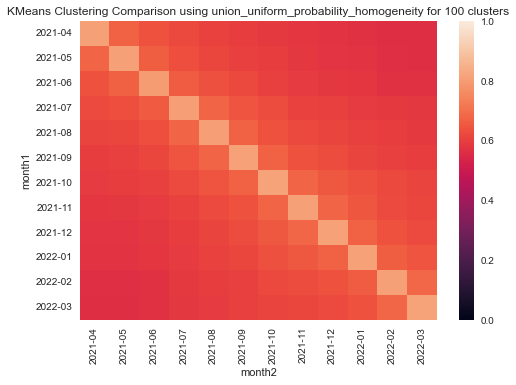

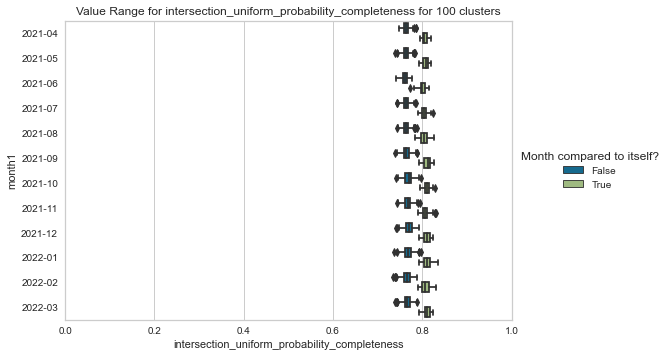

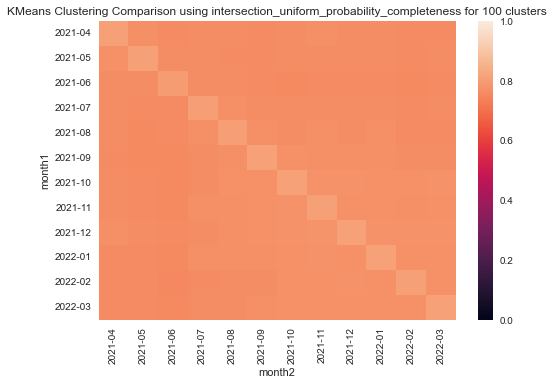

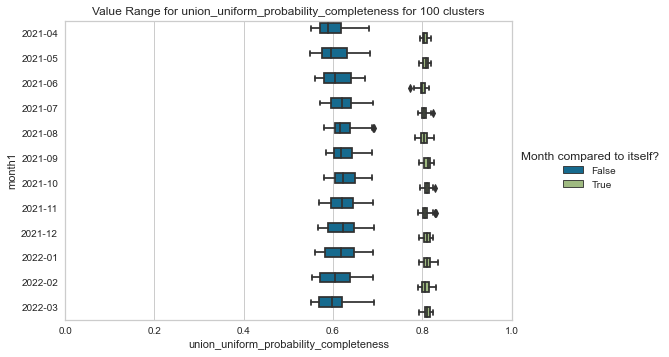

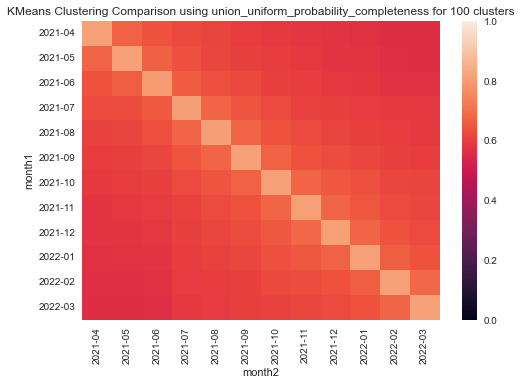

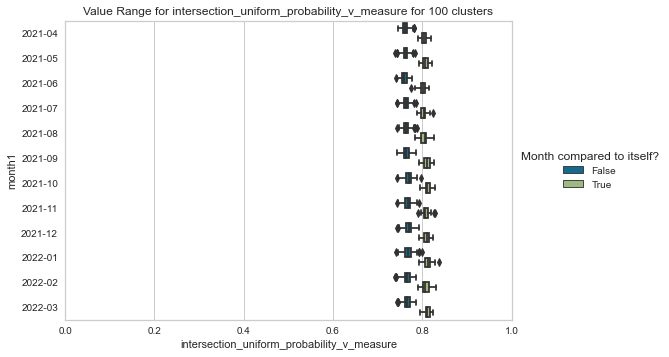

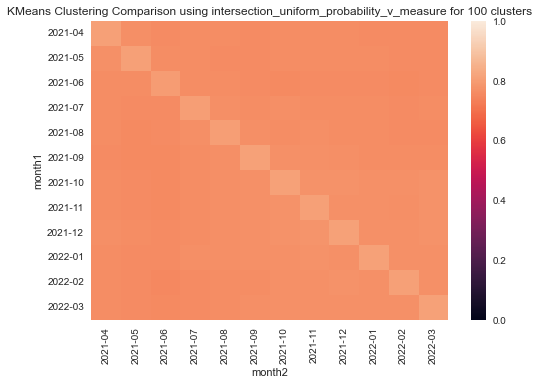

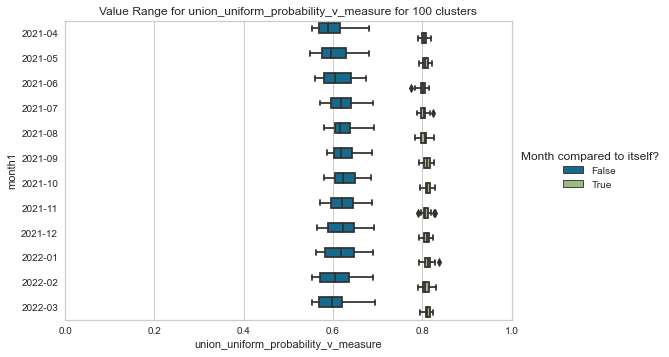

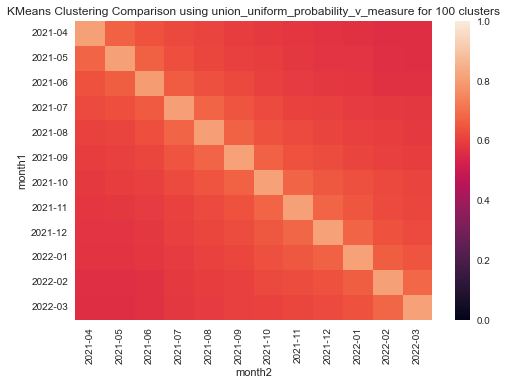

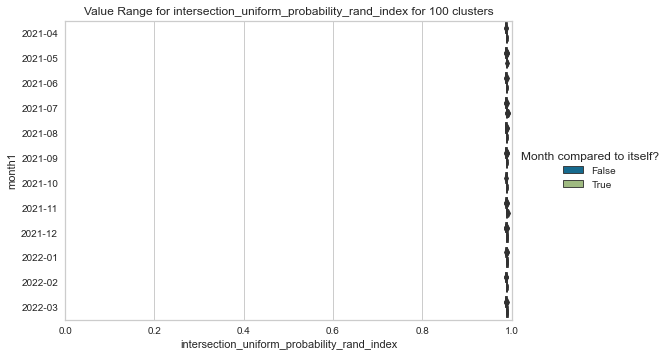

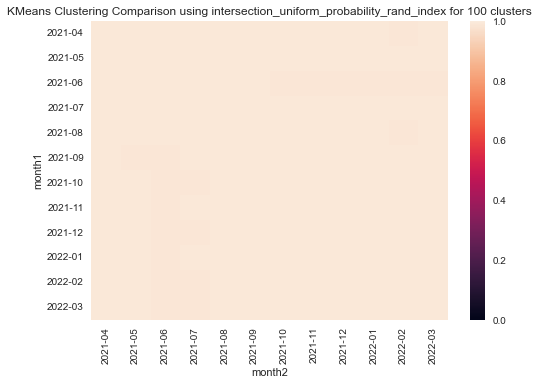

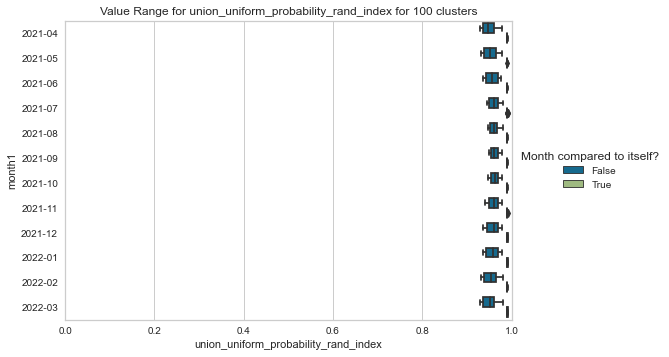

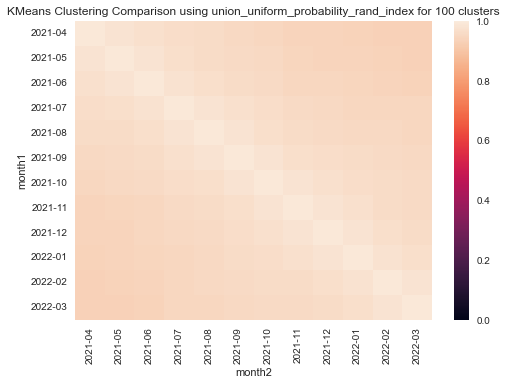

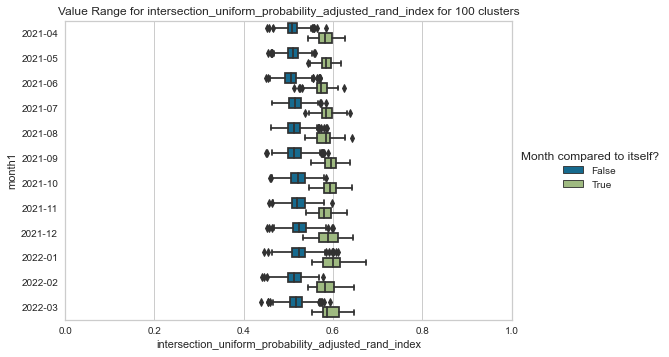

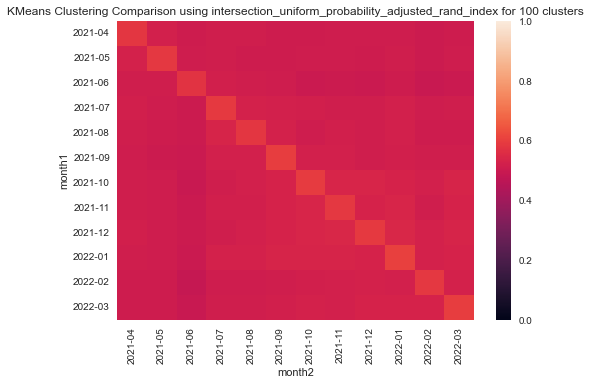

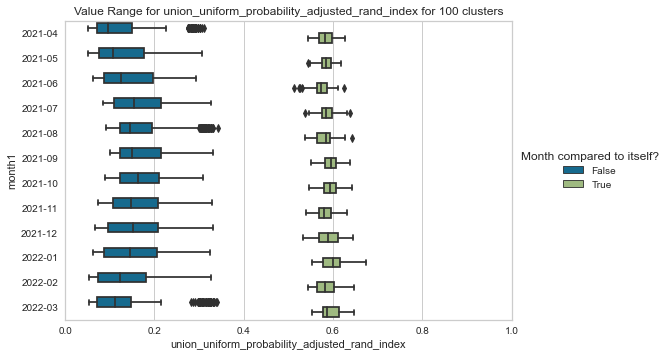

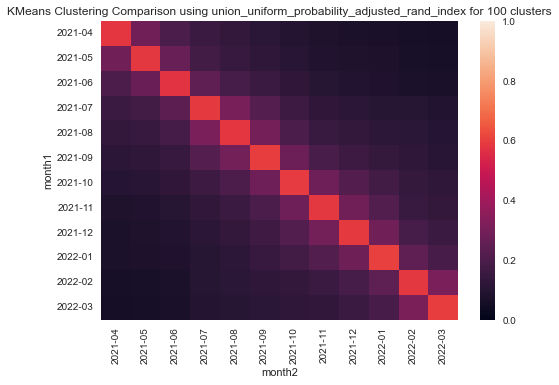

Num clusters: 175


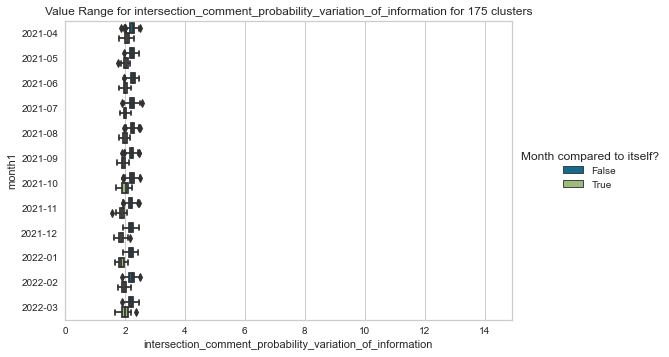

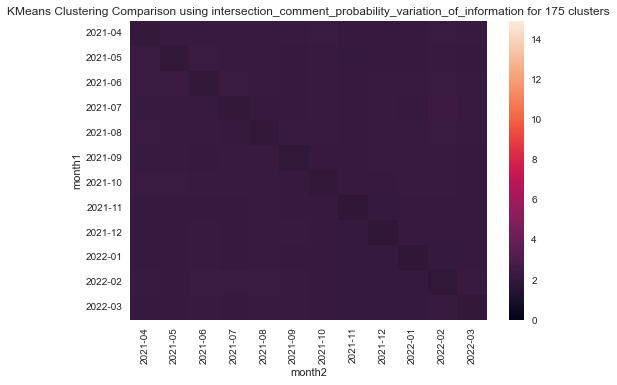

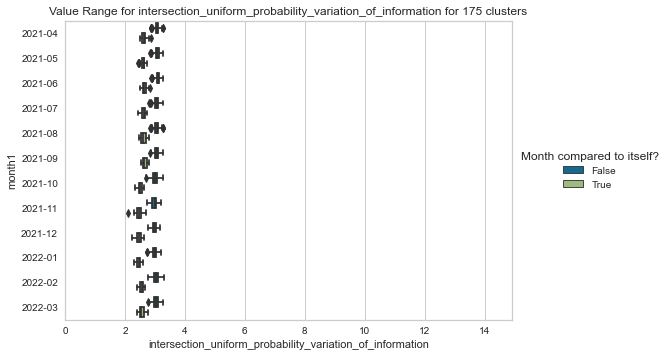

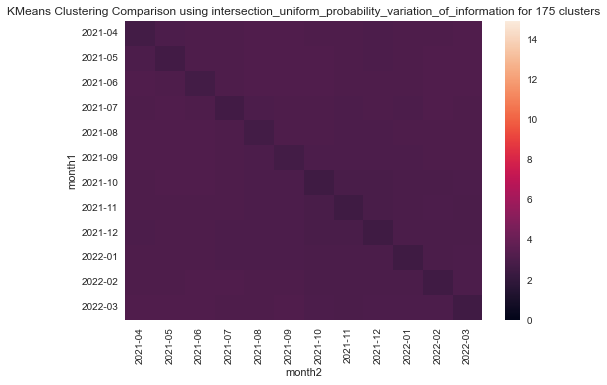

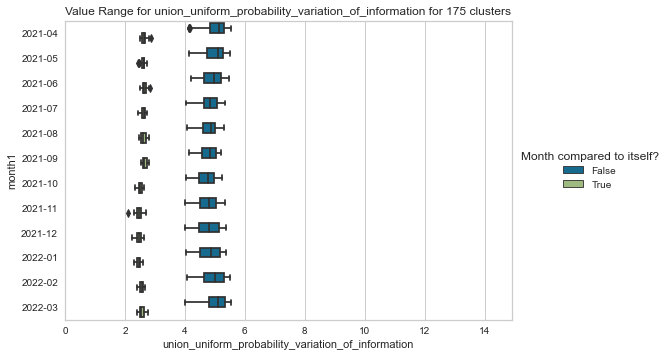

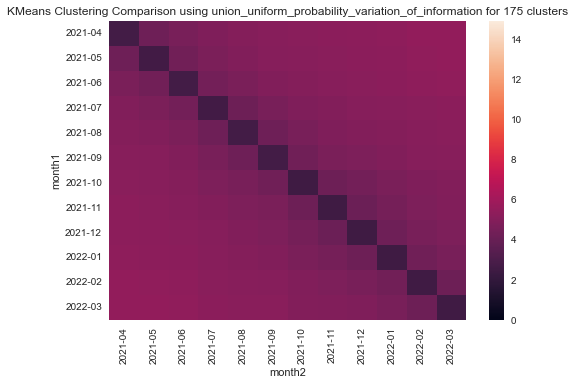

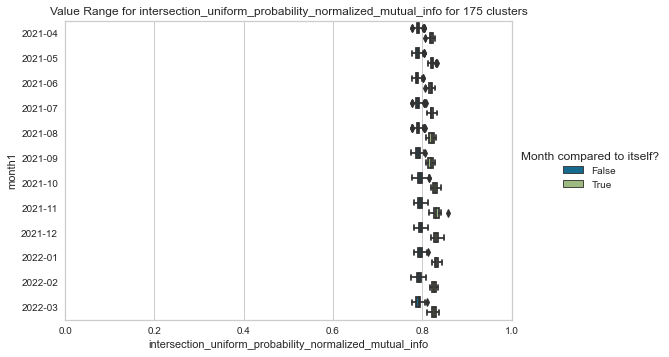

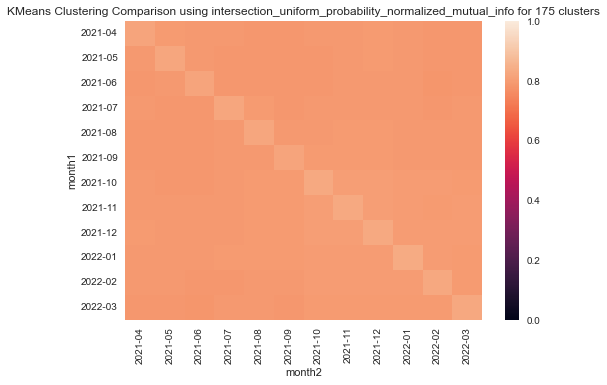

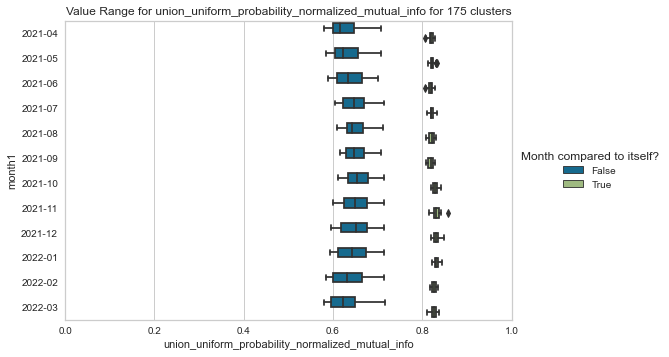

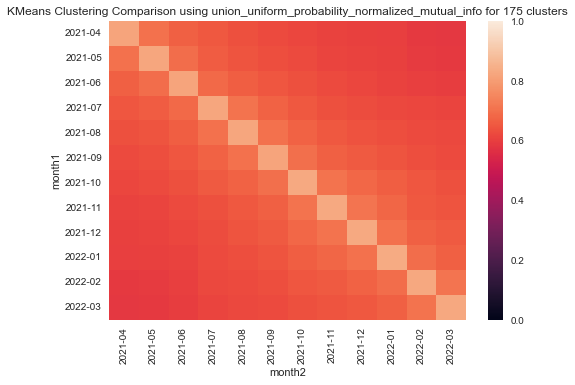

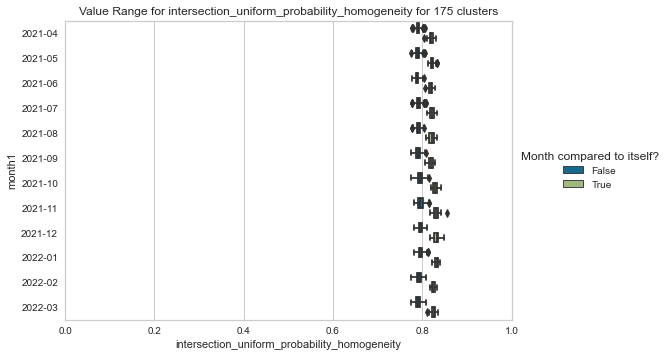

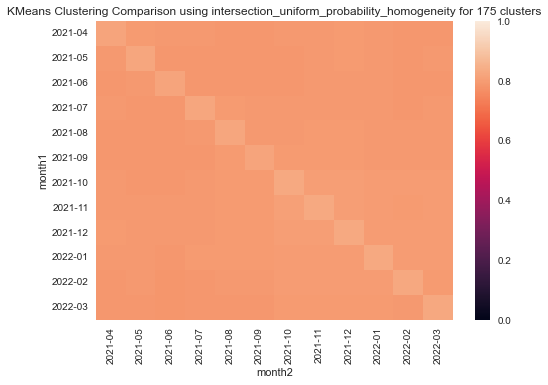

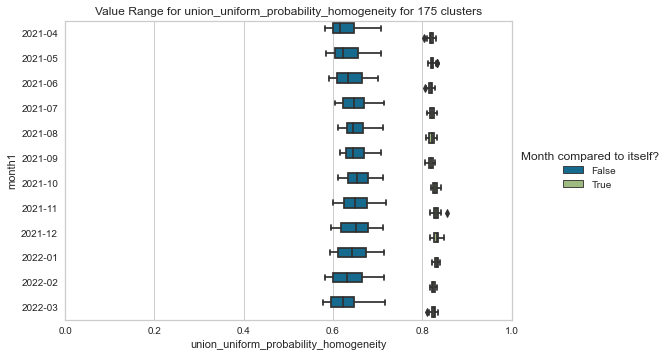

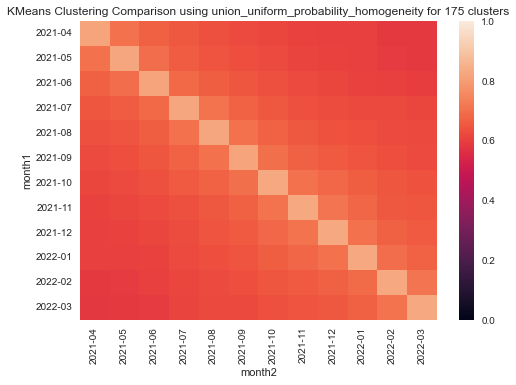

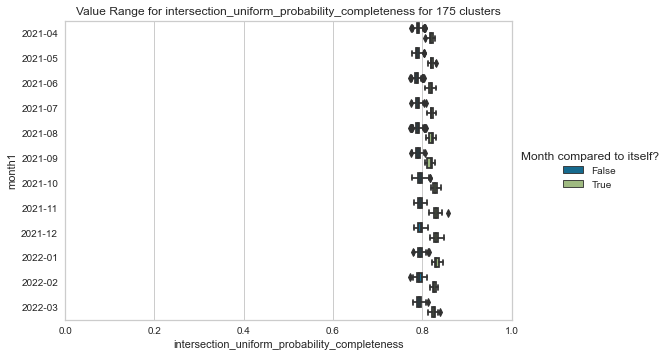

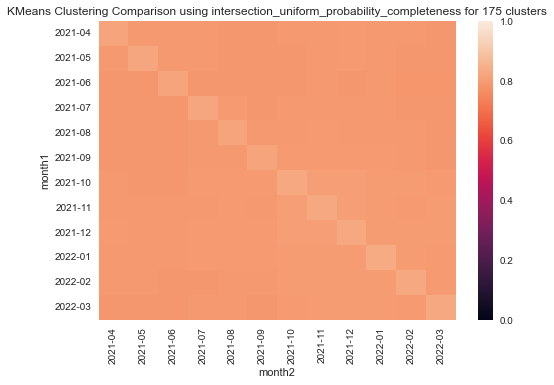

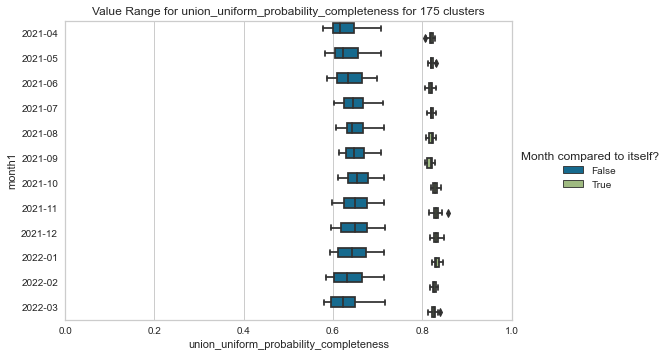

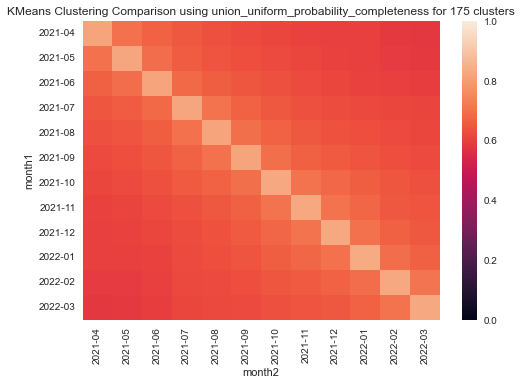

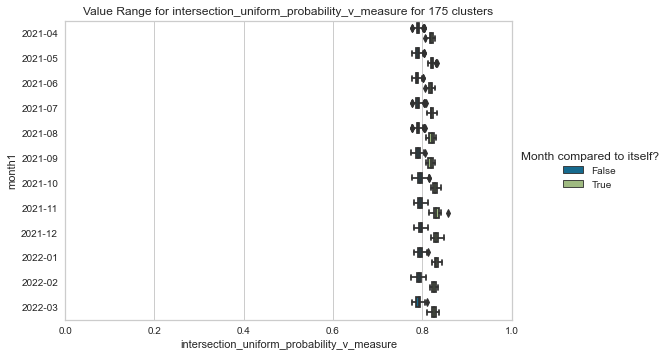

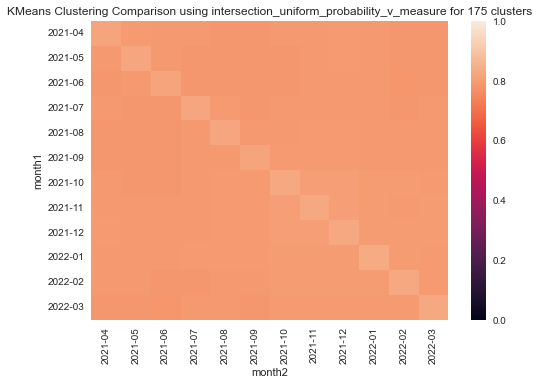

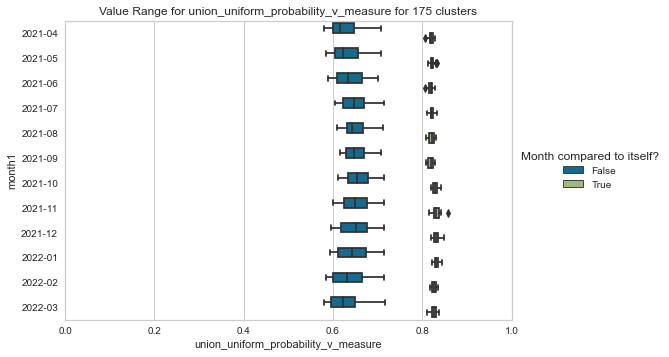

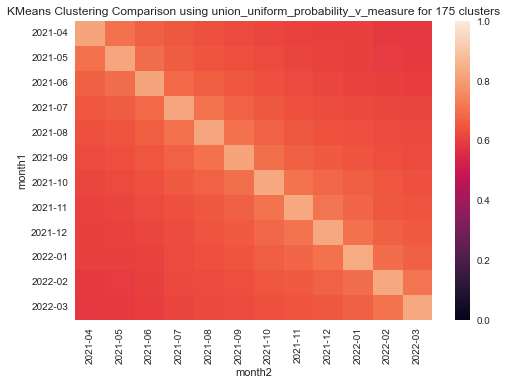

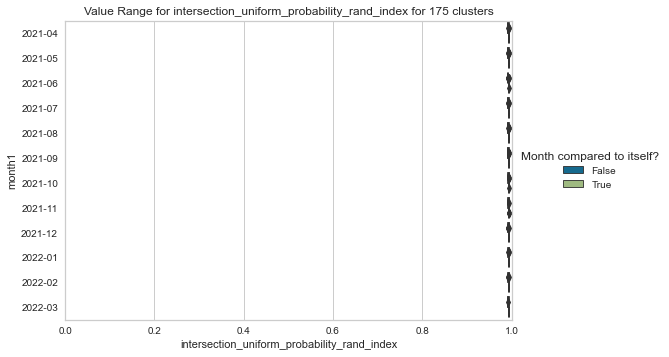

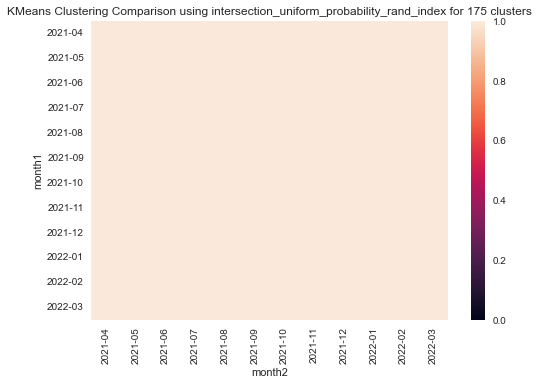

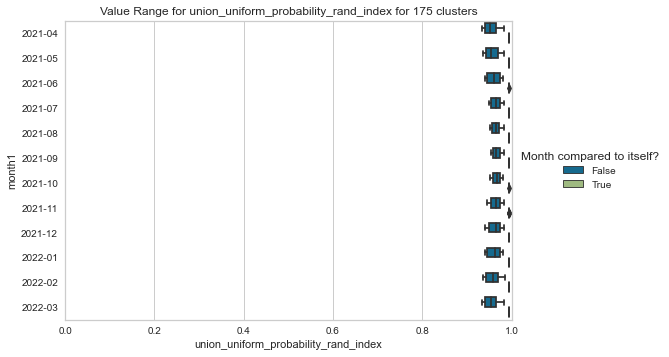

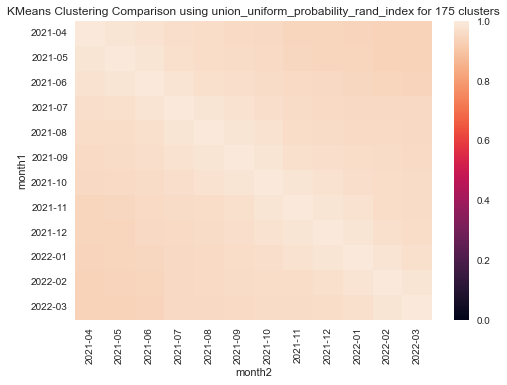

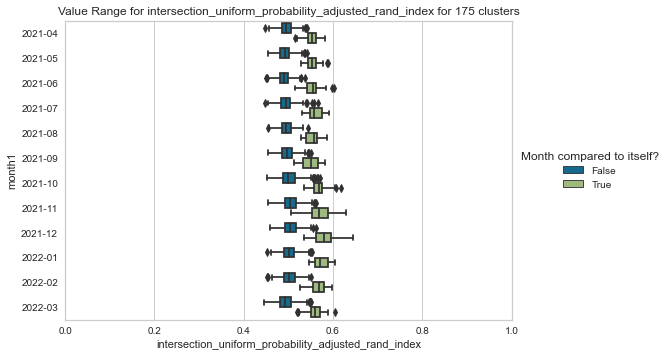

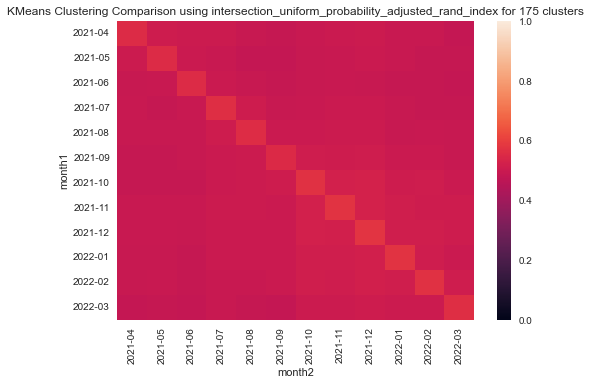

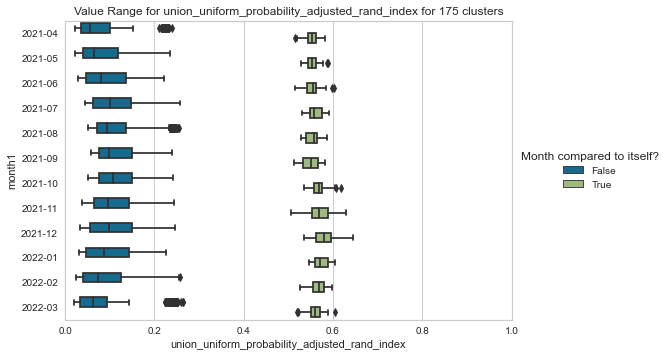

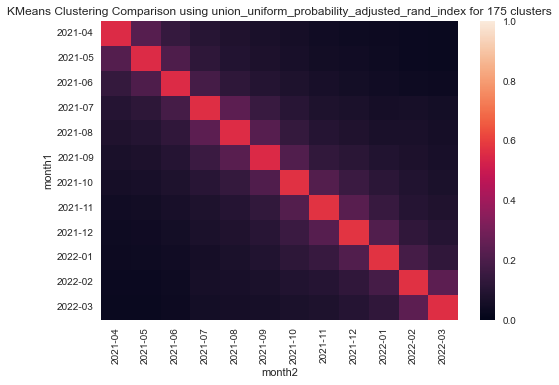

Num clusters: 250


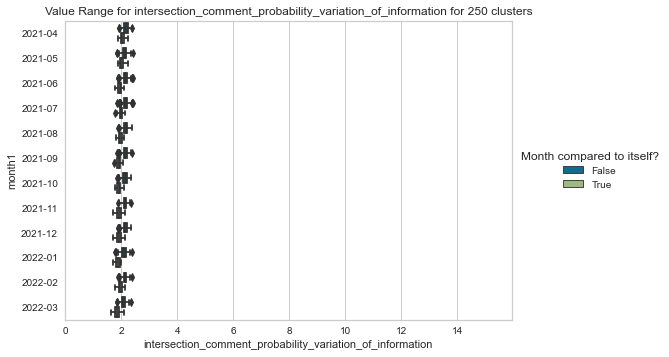

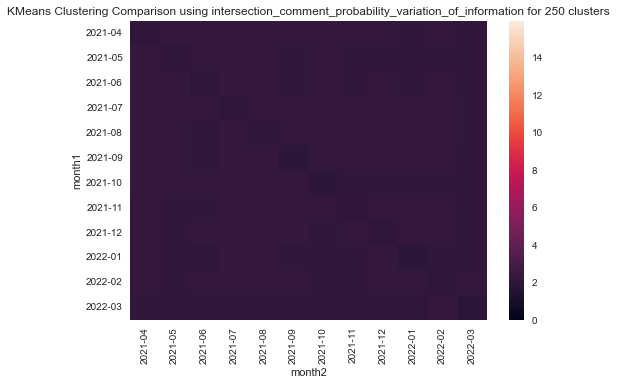

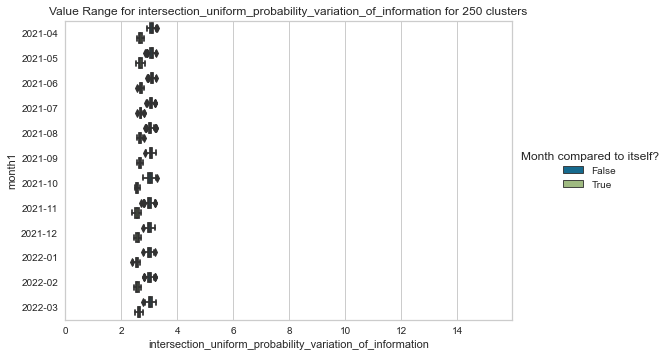

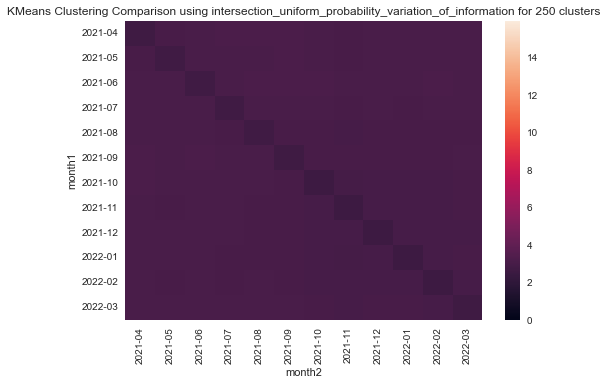

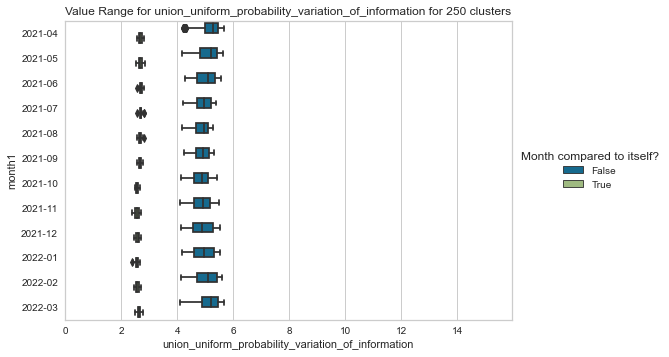

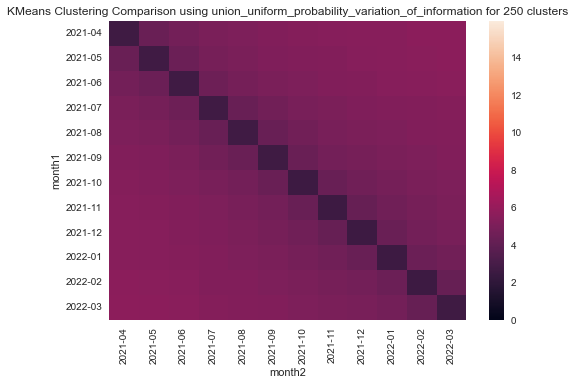

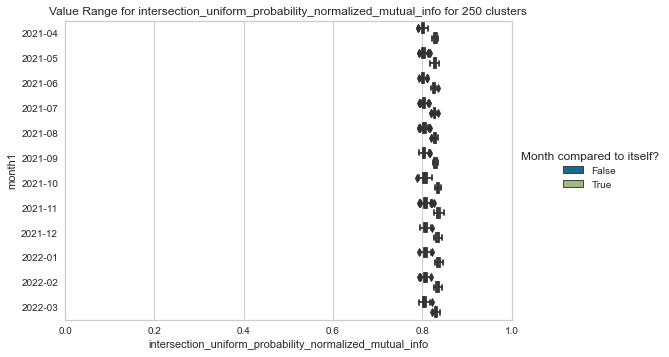

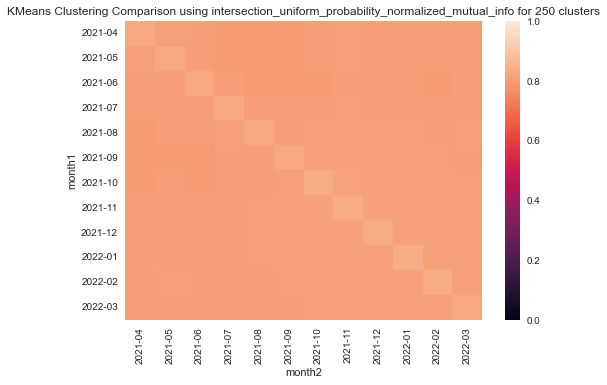

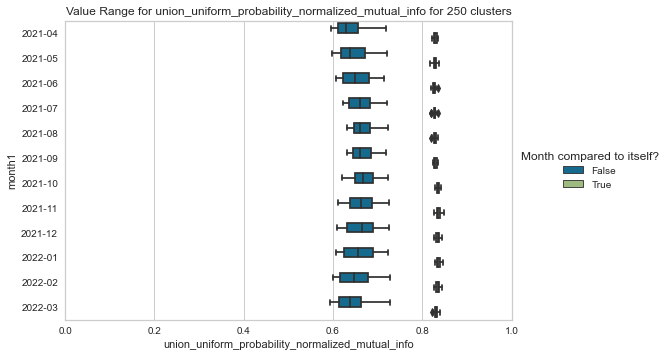

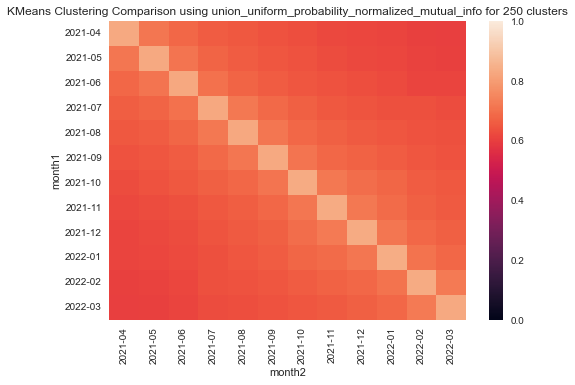

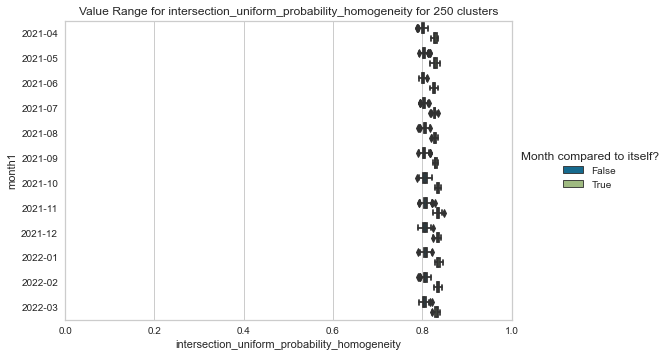

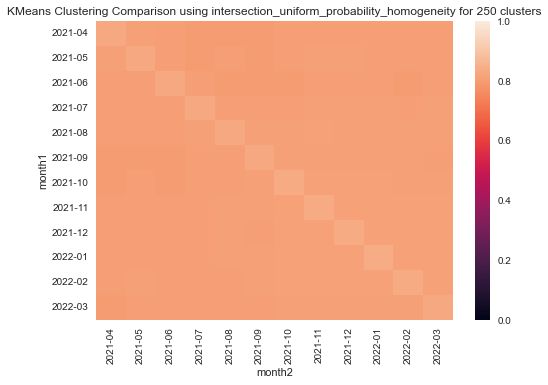

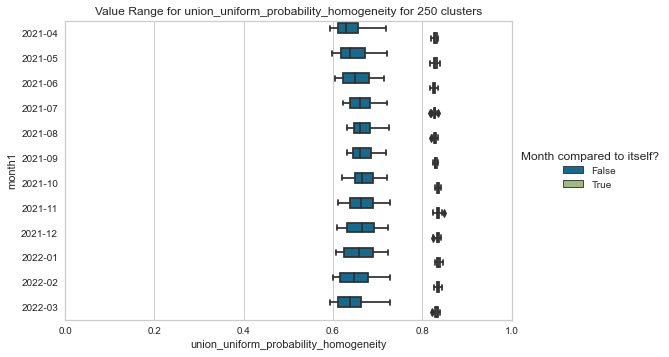

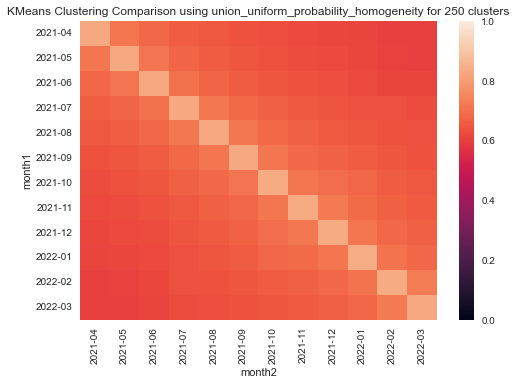

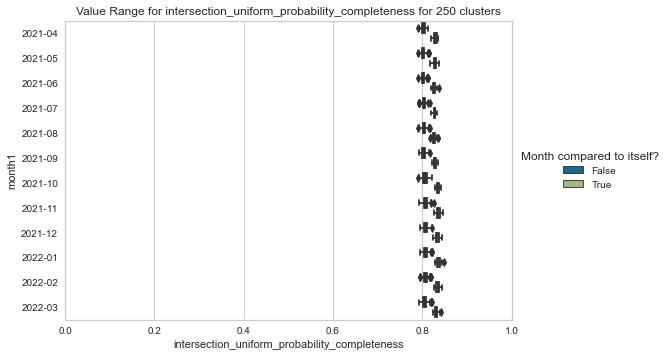

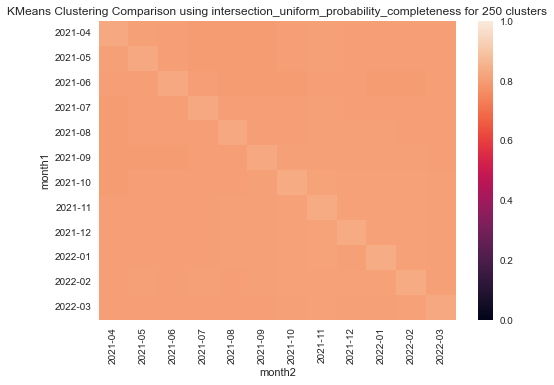

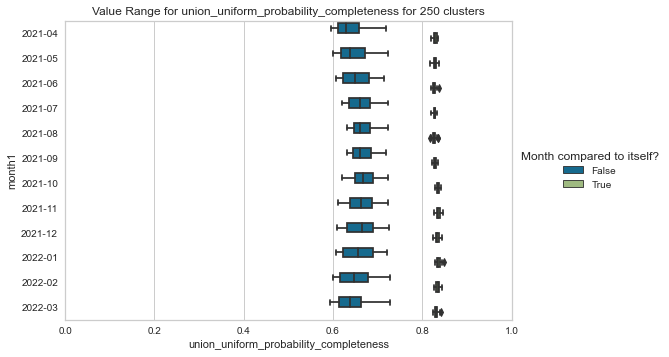

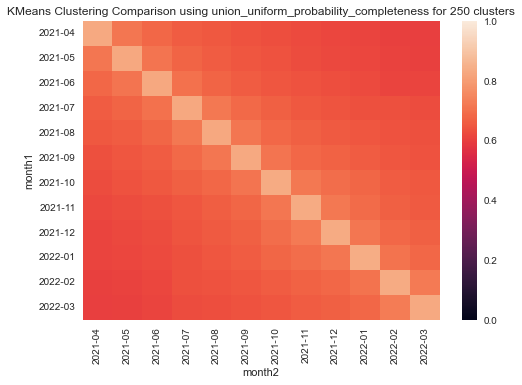

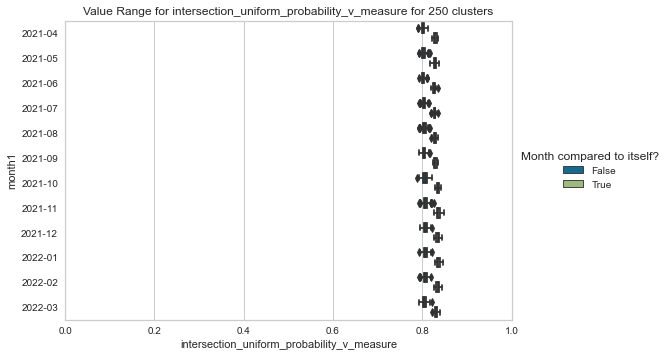

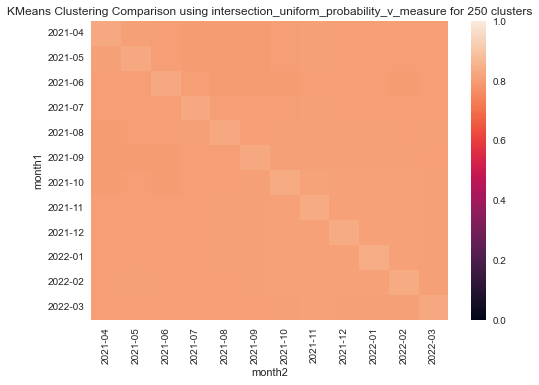

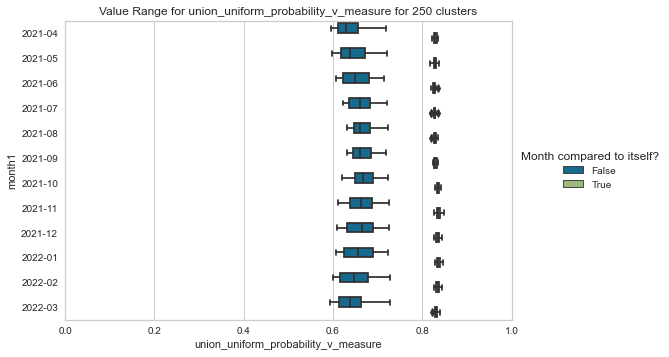

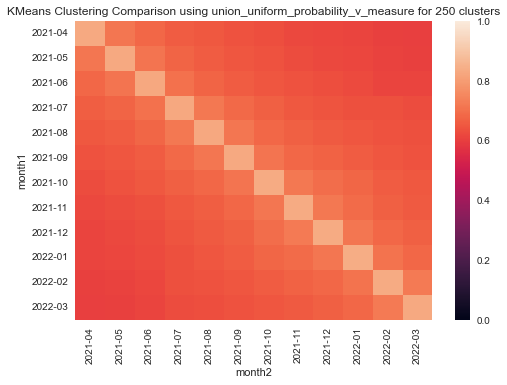

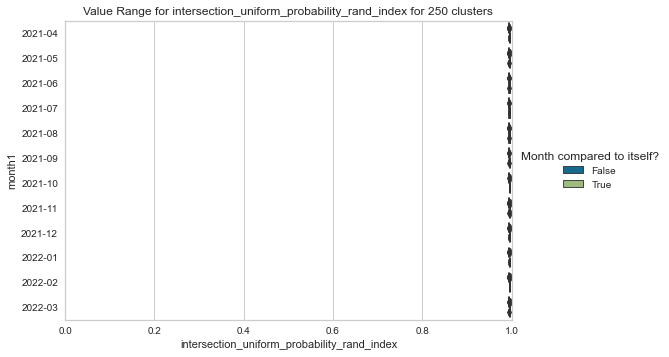

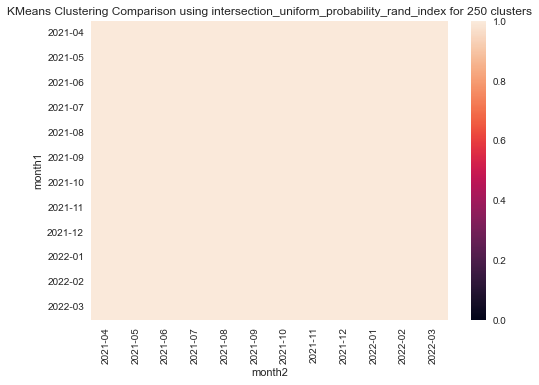

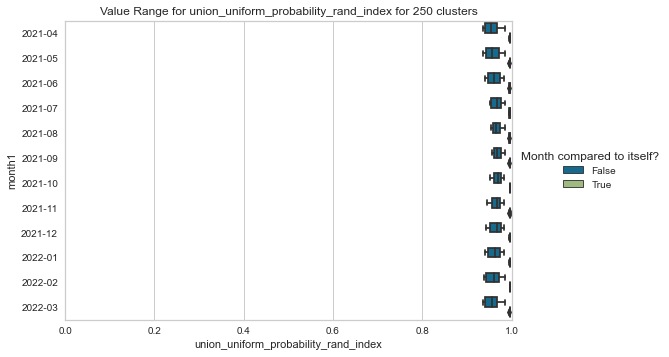

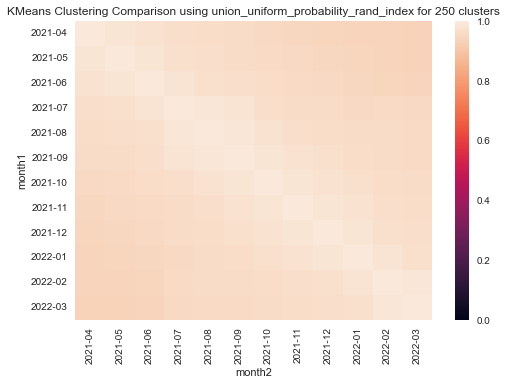

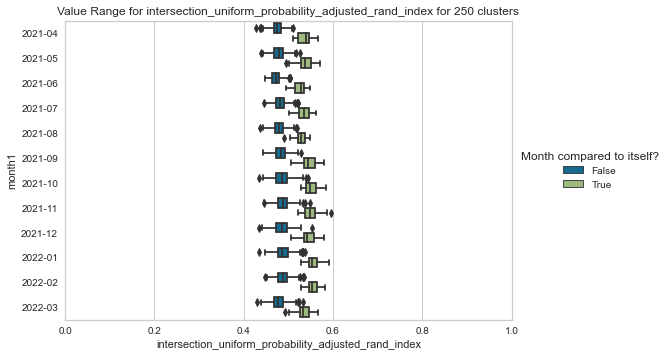

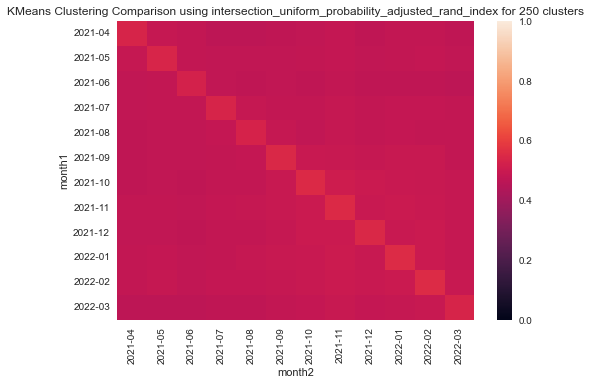

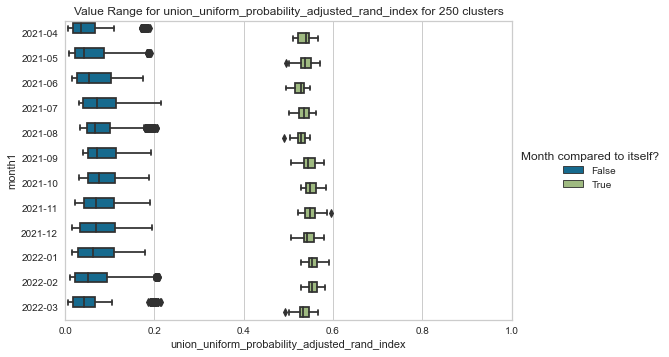

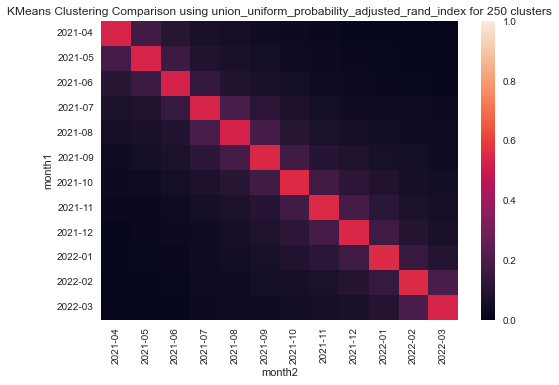

Num clusters: 400


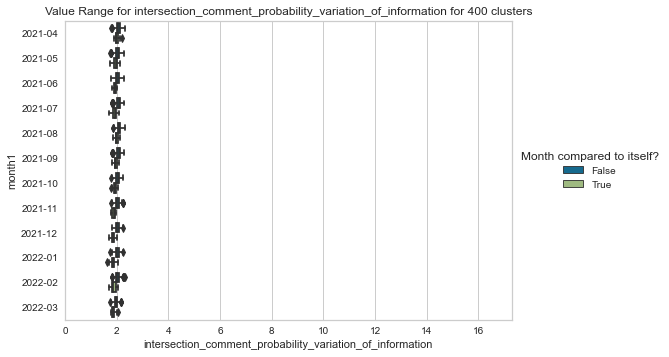

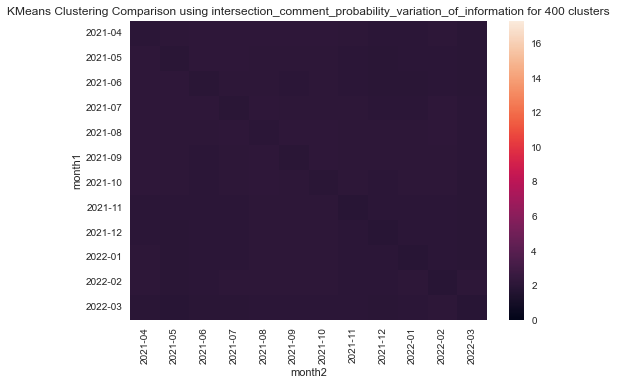

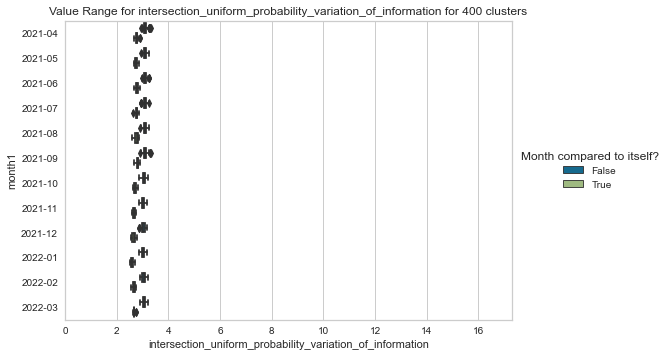

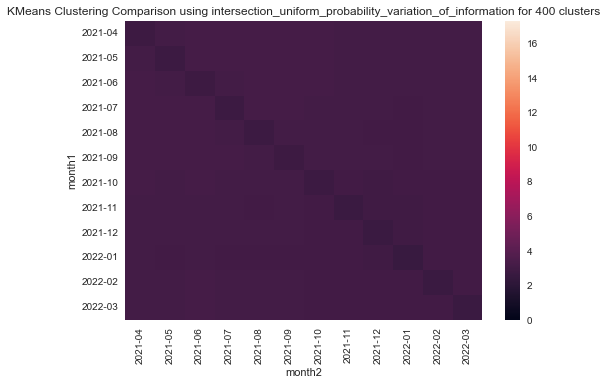

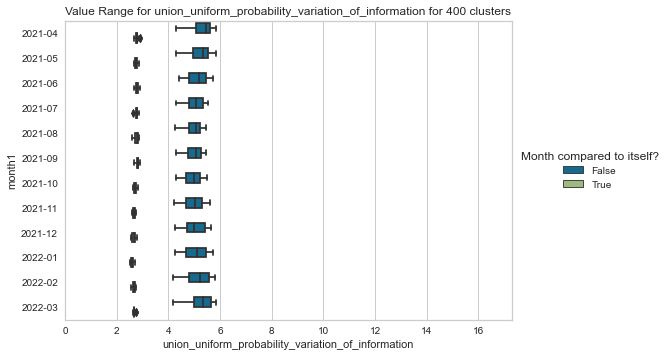

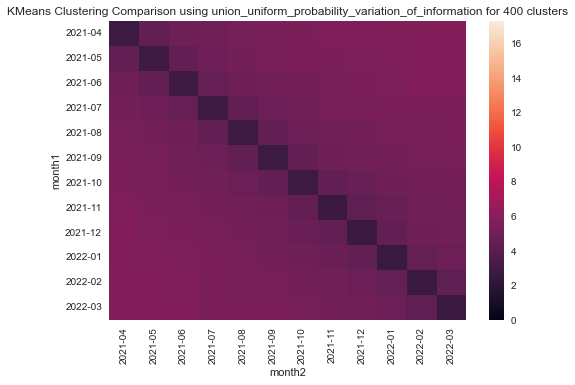

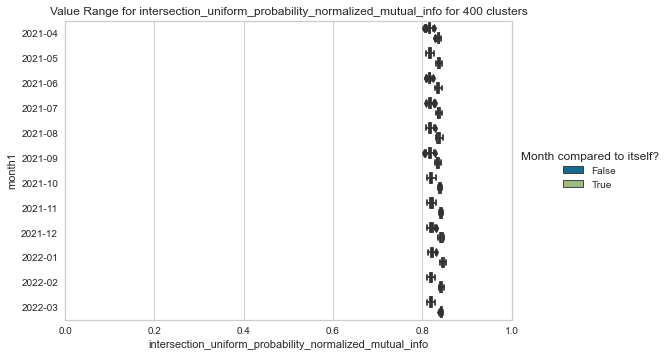

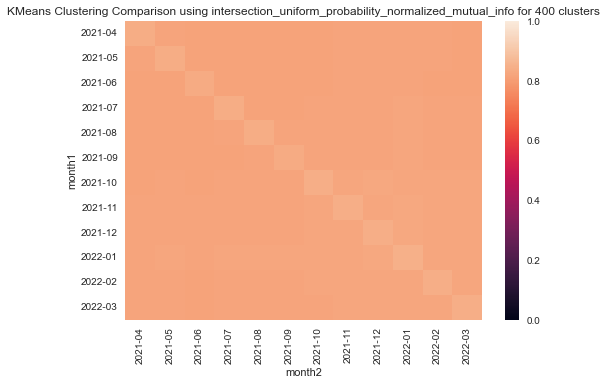

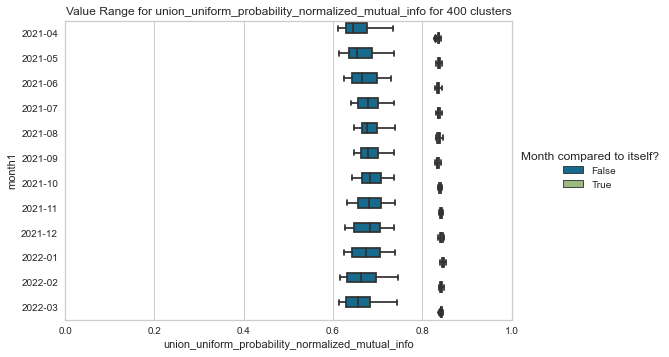

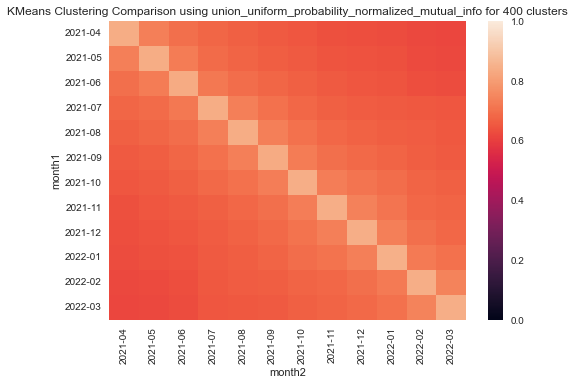

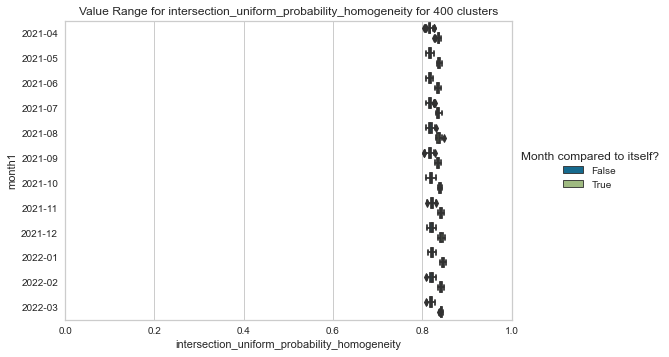

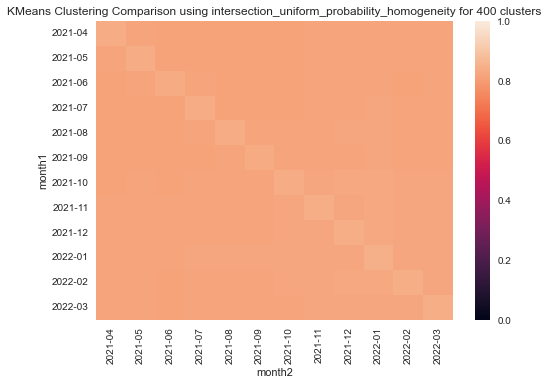

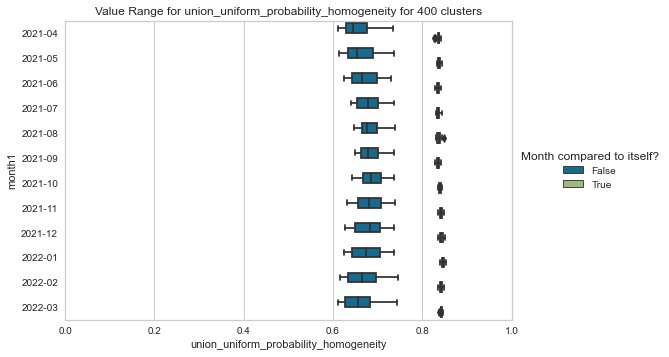

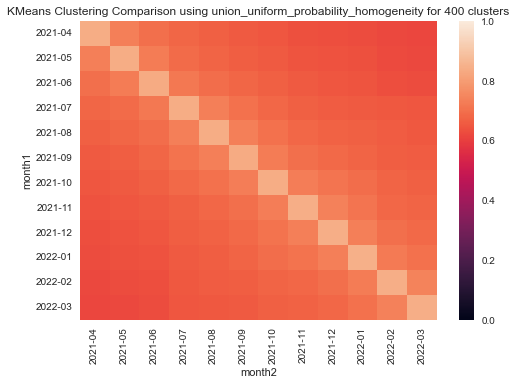

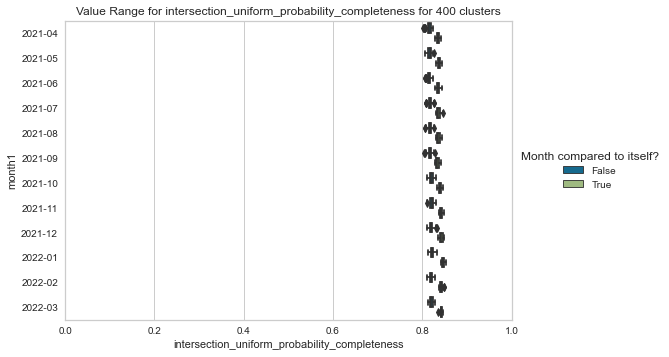

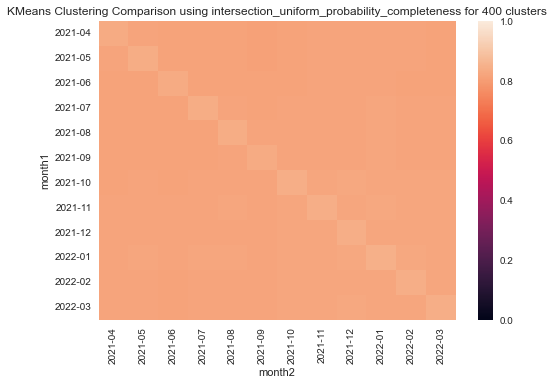

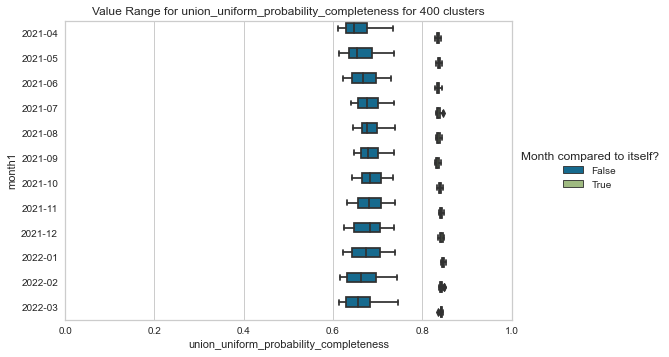

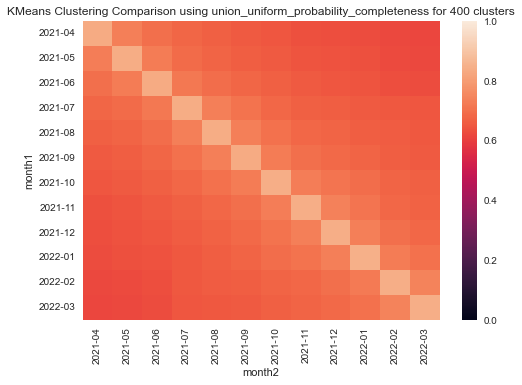

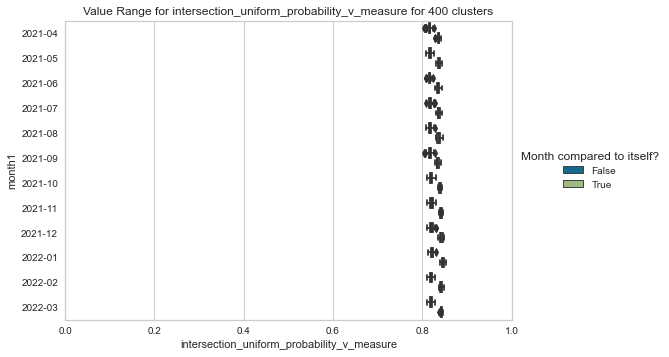

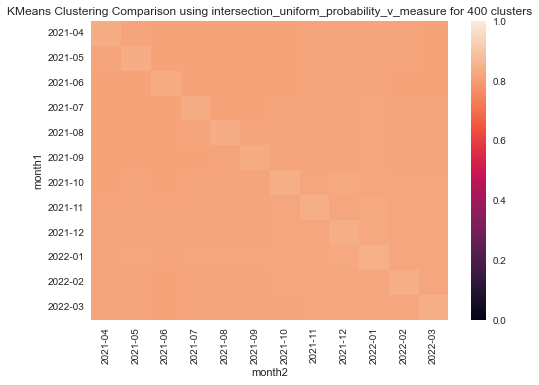

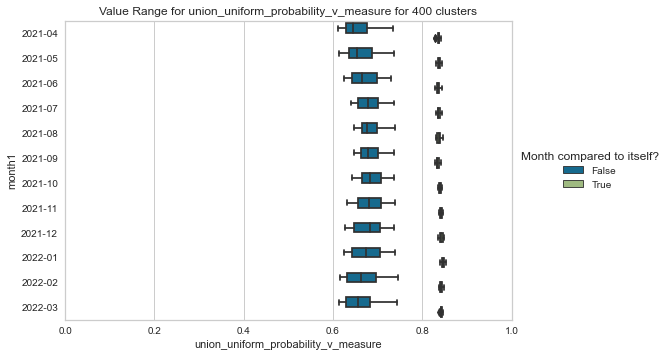

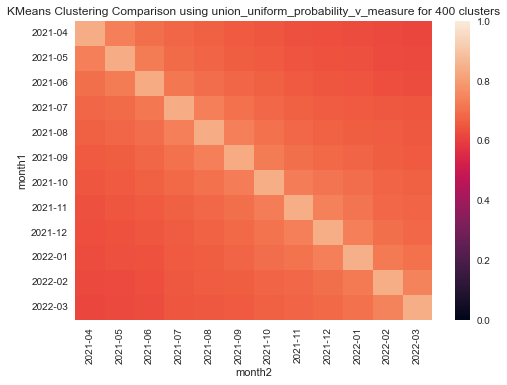

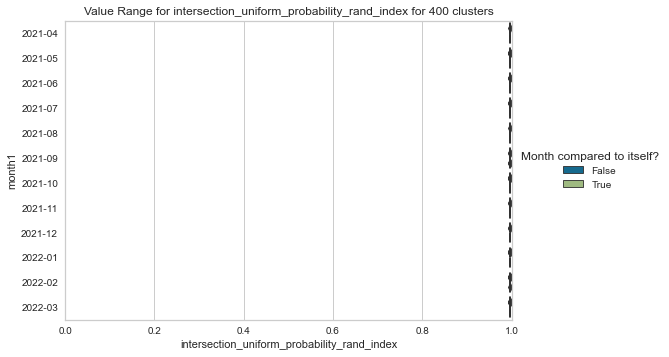

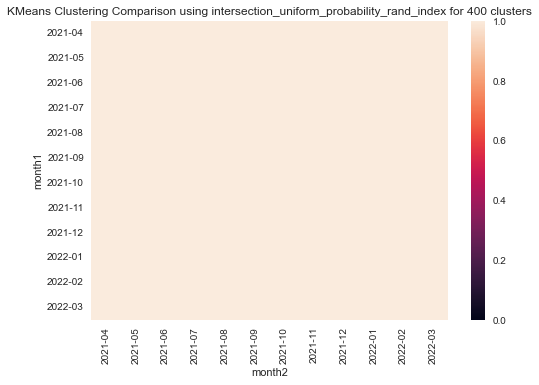

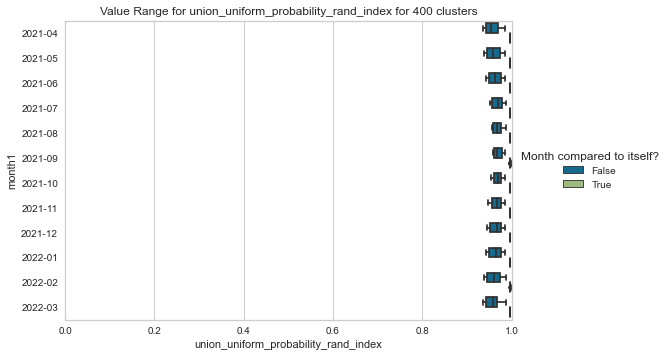

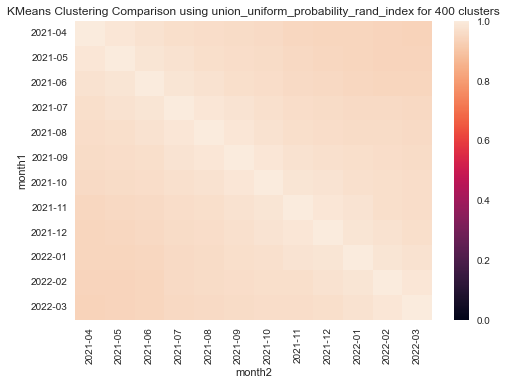

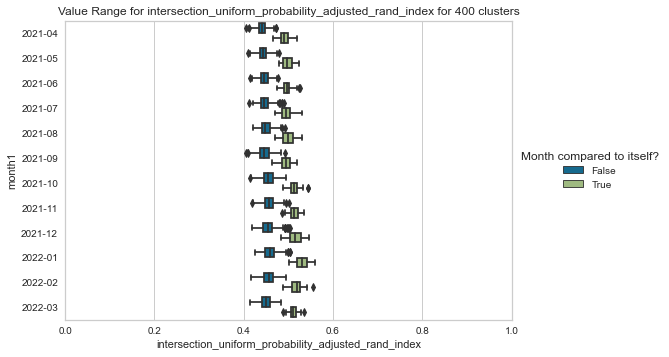

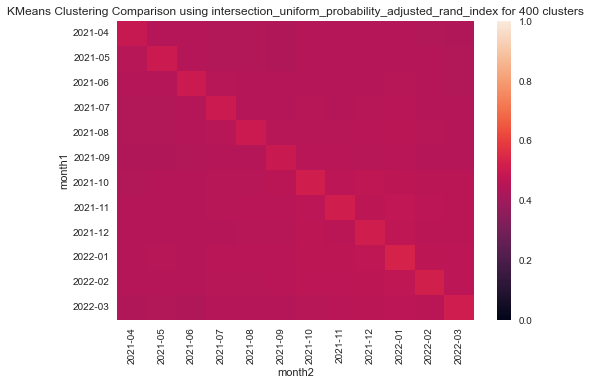

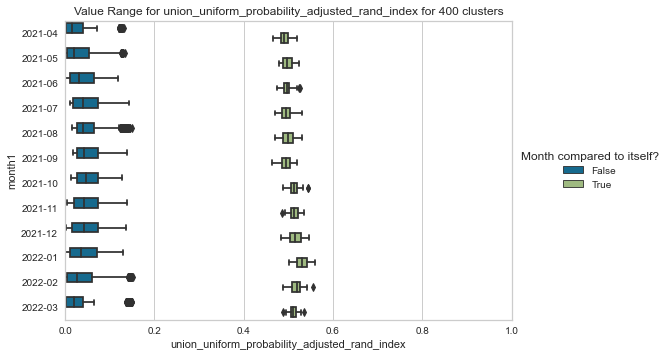

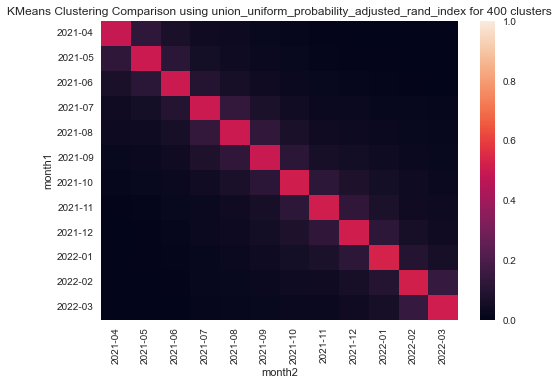

Num clusters: 500


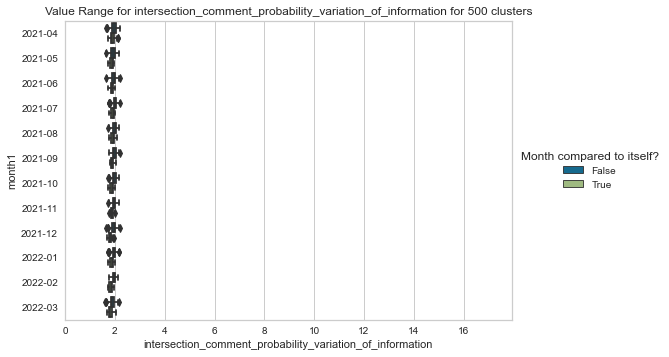

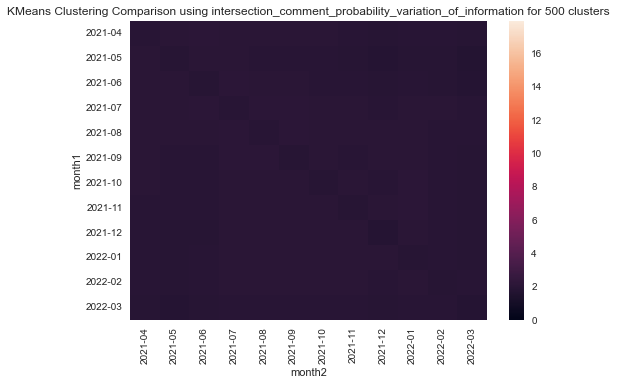

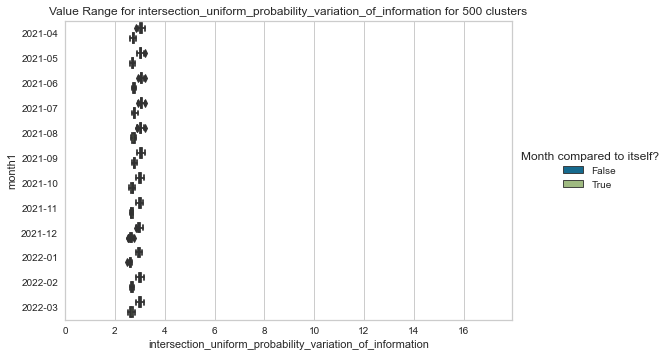

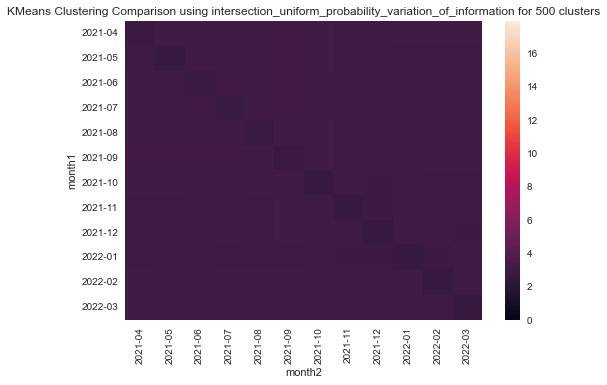

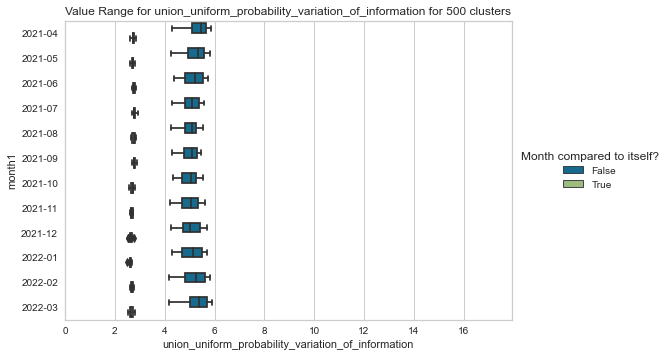

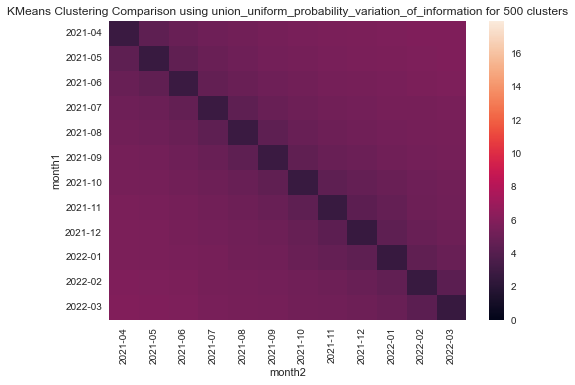

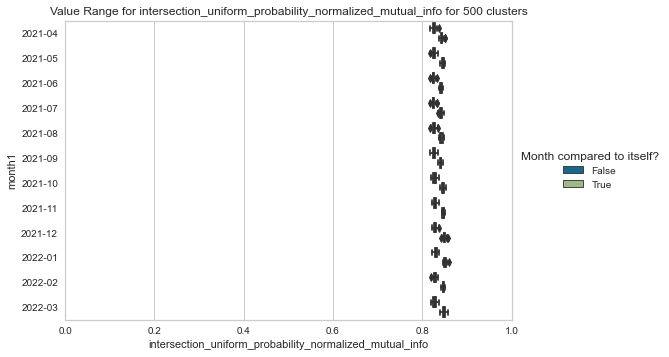

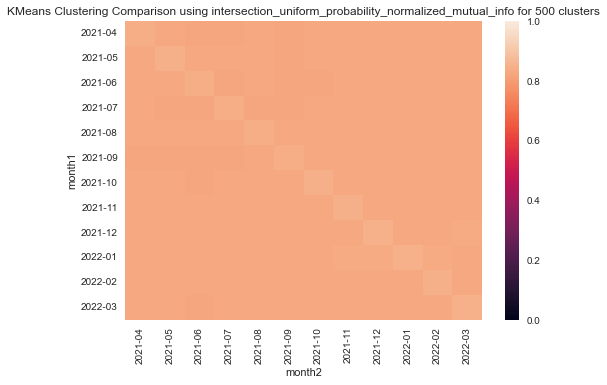

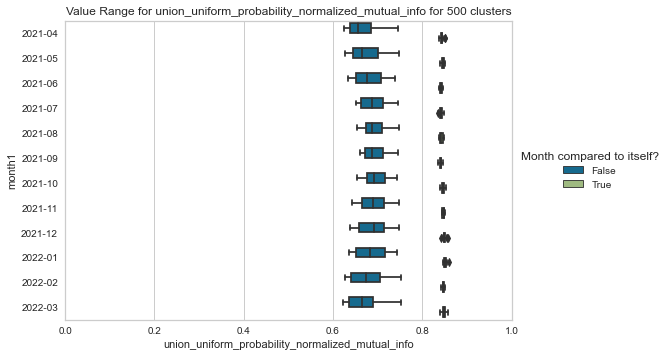

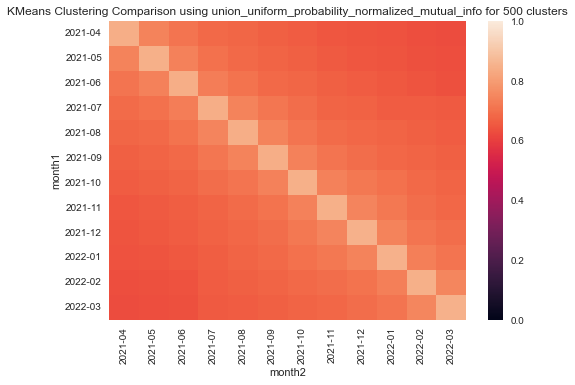

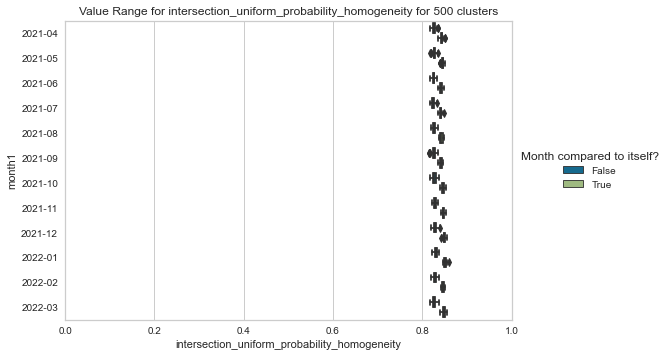

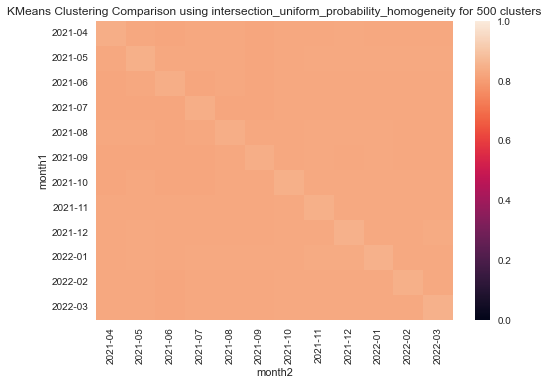

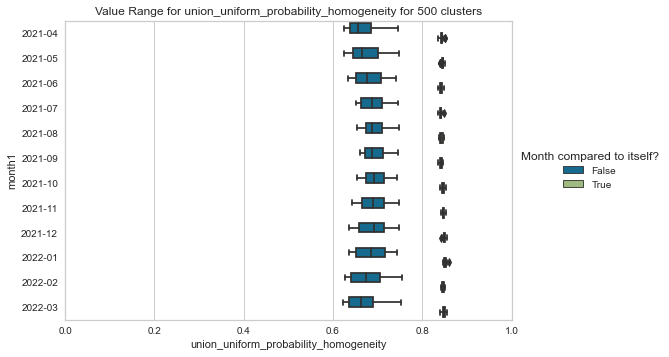

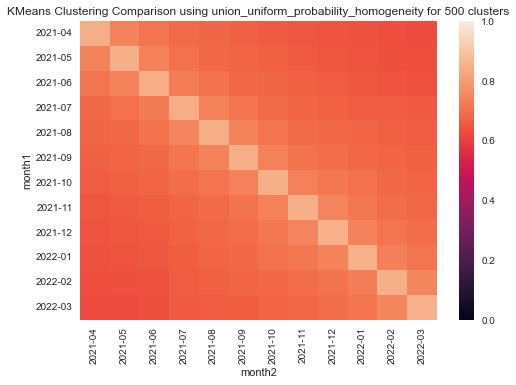

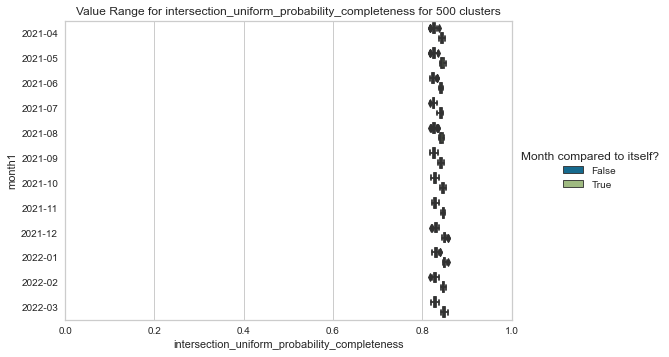

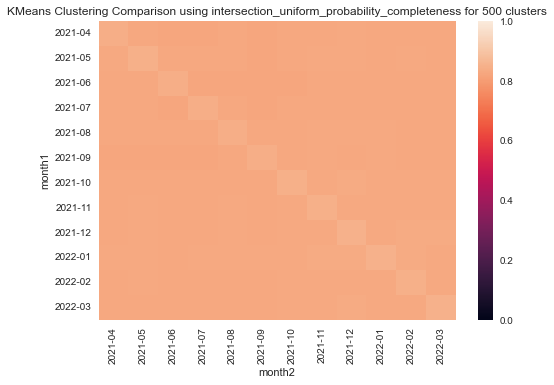

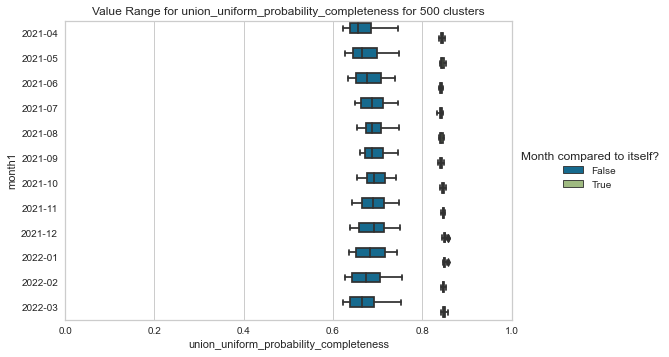

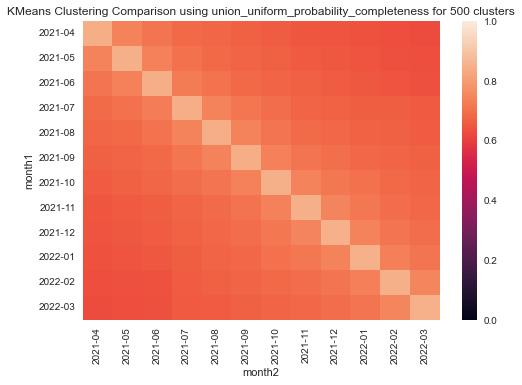

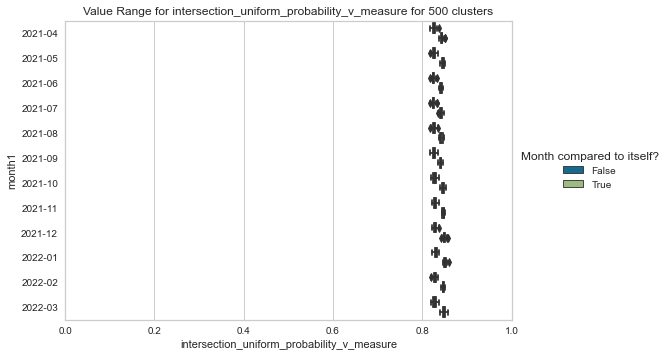

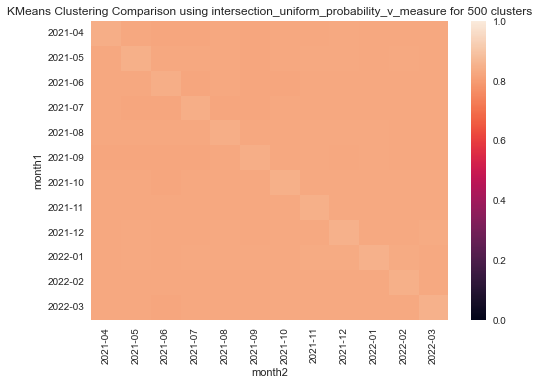

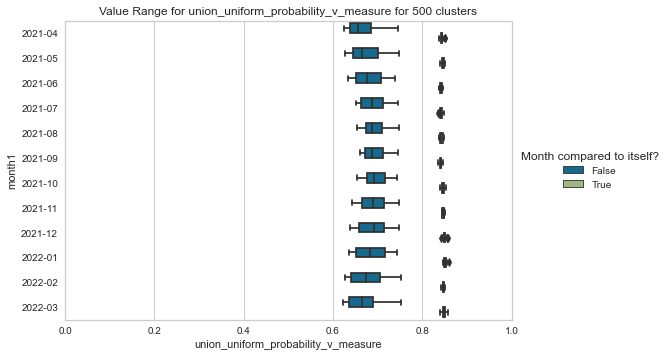

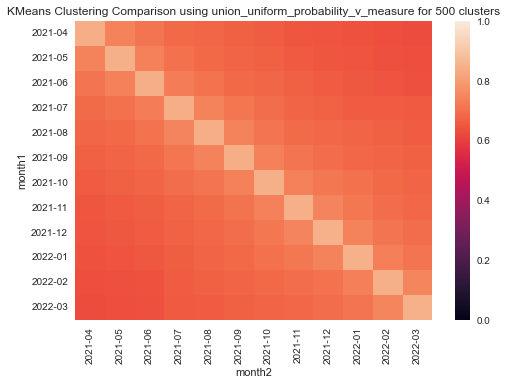

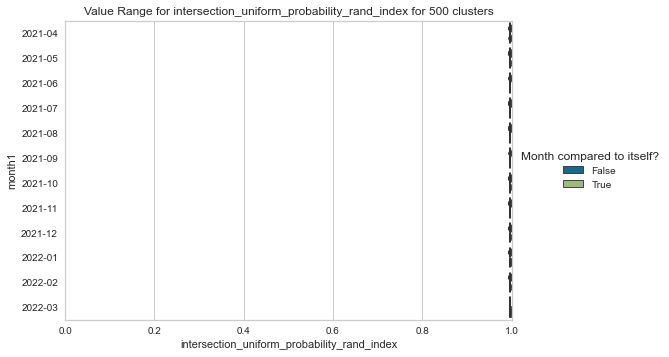

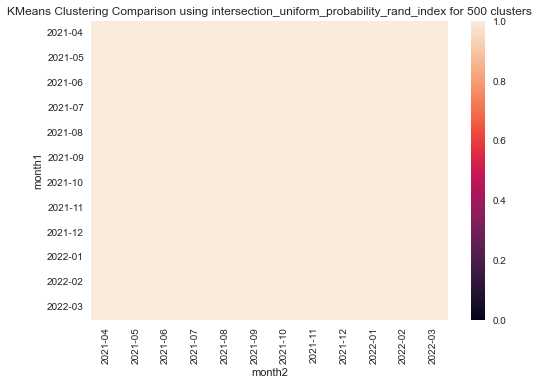

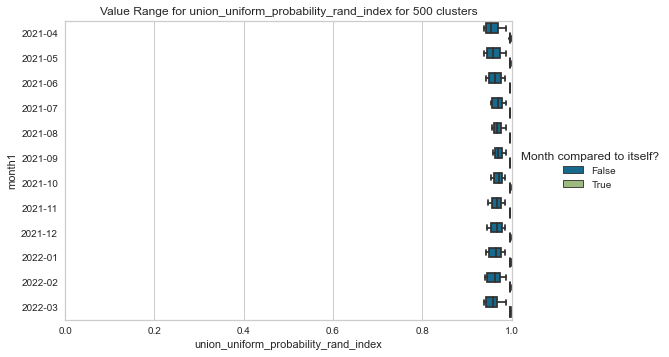

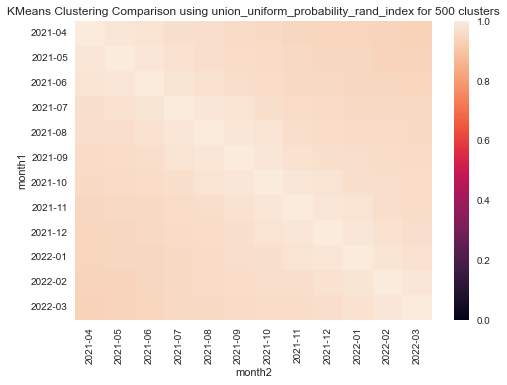

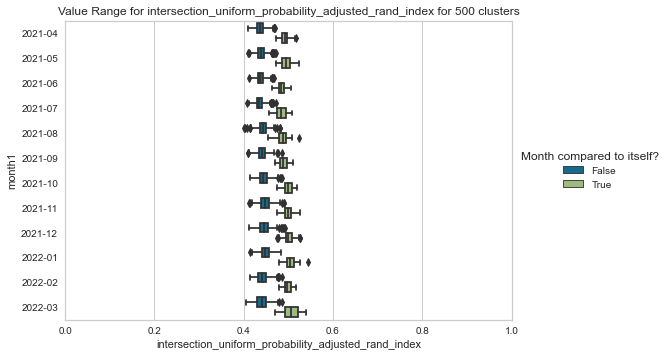

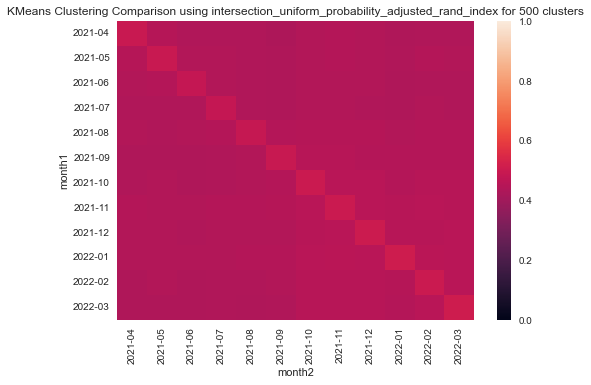

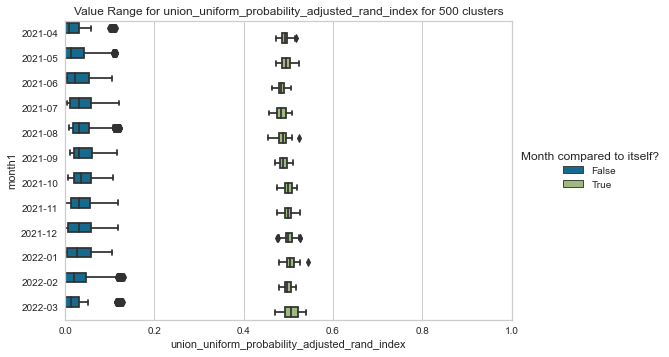

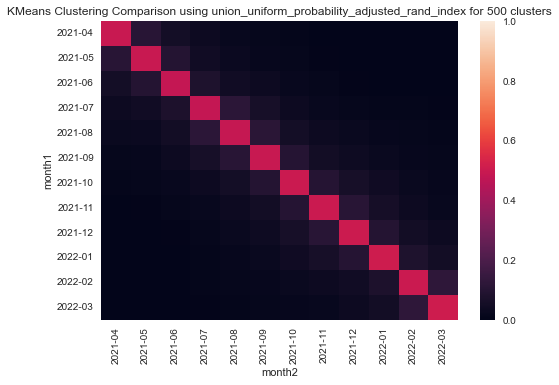

<Figure size 576x396 with 0 Axes>

In [4]:
for n_clusters in NUM_CLUSTERS:
    print("Num clusters:", n_clusters)
    for cluster_comp_metric in ["intersection_comment_probability_variation_of_information", "intersection_uniform_probability_variation_of_information", "union_uniform_probability_variation_of_information", "intersection_uniform_probability_normalized_mutual_info", "union_uniform_probability_normalized_mutual_info", "intersection_uniform_probability_homogeneity", "union_uniform_probability_homogeneity","intersection_uniform_probability_completeness", "union_uniform_probability_completeness", "intersection_uniform_probability_v_measure", "union_uniform_probability_v_measure", "intersection_uniform_probability_rand_index", "union_uniform_probability_rand_index","intersection_uniform_probability_adjusted_rand_index", "union_uniform_probability_adjusted_rand_index"]:
        vmin = 0
        if "variation_of_information" in cluster_comp_metric:
            # Max of VOI is H(C) + H(C') when both have uniform porbabiltiies
            vmax = -2*np.log2(1/n_clusters)
        else:
            vmax=1
        n_cluster_experiments = cluster_comparison_df[cluster_comparison_df["n_clusters"] == n_clusters].copy()
        n_cluster_experiments["month compared to itself"] = n_cluster_experiments["month1"] == n_cluster_experiments["month2"]
        sns.boxplot(data=n_cluster_experiments, x=cluster_comp_metric, y="month1", hue="month compared to itself").set_title(f"Value Range for {cluster_comp_metric} for {n_clusters} clusters")
        plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), title="Month compared to itself?")
        plt.xlim(vmin, vmax)
        plt.show()
        plt.clf()
        sns.heatmap(n_cluster_experiments.pivot_table(index="month1", columns="month2", values=cluster_comp_metric), vmin=vmin, vmax=vmax).set_title(f"KMeans Clustering Comparison using {cluster_comp_metric} for {n_clusters} clusters")
        plt.show()
        plt.clf()
